# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
#!pip install tensorflow[and-cuda] numpy==1.25.2 -q
!pip install numpy==1.25.2 pandas==2.0.3 seaborn==0.13.1 tensorflow==2.15.0 scikit-learn==1.2.2 matplotlib==3.7.1 -q

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.18.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [3]:
#Uncomment and run the following code in case Google Colab is being used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/images_proj.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels_proj.csv')

# **Exploratory Data Analysis**

Data Overview
Let's print the shape of the images and labels

In [5]:
print(images.shape)
print(labels.shape)


(631, 200, 200, 3)
(631, 1)


A sample colored imange with label:1


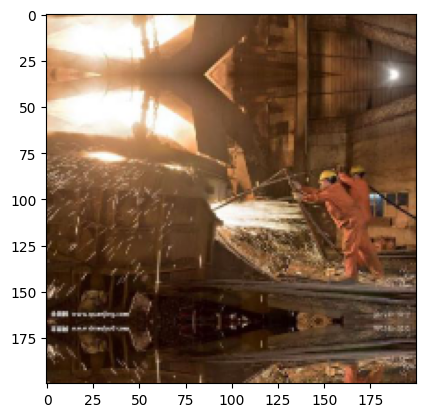

In [6]:
# Converting images from BGR to RGB
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
plt.imshow(images[5])
print('A sample colored imange with label:{}'.format(labels['Label'][99]))

### Observation
* The dataset contains 631 colored images with 200 X 200 pixel.
* The image has three color channel BGR (B=Blue, G=Green, R=Red).
* It has its label, image with or without safety helmet.
* We converted image to BGR to RGB to plot it to matplotlib as it supports RGB.

###Plot random images from each of the classes and print their corresponding labels.

### A sample image with helmet

A sample imange (image no: 99) with label:1


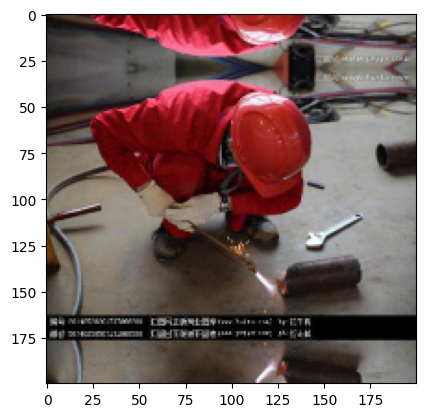

In [7]:
plt.imshow(images[99])
print('A sample imange (image no: 99) with label:{}'.format(labels['Label'][99]))




### A sample image without helmet

A sample imange (image no: 361) with label:0


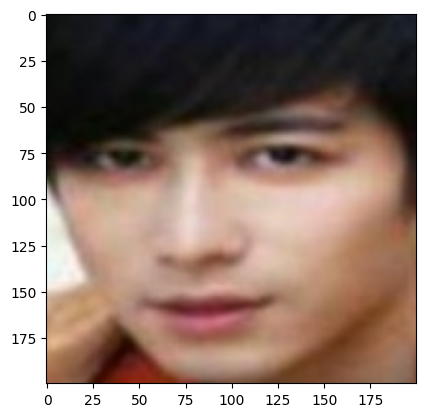

In [8]:
plt.imshow(images[361])
print('A sample imange (image no: 361) with label:{}'.format(labels['Label'][361]))


## Checking for class imbalance


In [ ]:
labels['Label'].value_counts()

Label
0    320
1    311
Name: count, dtype: int64

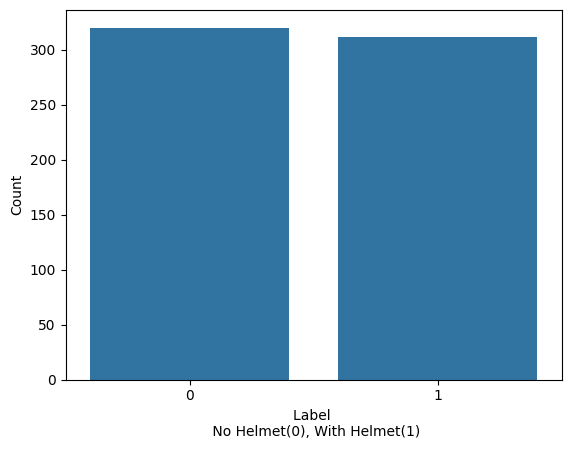

In [ ]:
ax = sns.countplot(x=labels['Label'])
ax.set_xlabel('Label \n No Helmet(0), With Helmet(1)')
ax.set_ylabel('Count')
#ax.set_title('No Helmet(0), With Helmet(1)')
plt.show();

### Observation

* Dataset is balanced.
* It has 320 images without helmet (class as 0).
* It has 311 images with helmet (class as 1).

# **Data Preprocessing**

In [ ]:
labels_class = {0: 'No Helmet(0)', 1: 'Helmet(1)'}

# This functions takes images and its label and plot them
def plot_images(imges,image_labels, cmap='gray'):
  num_classes=2                                                                  # Number of Classes
  categories=np.unique(image_labels)
  keys=dict(image_labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(12, 12))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(image_labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          if cmap is not 'gray':
            ax.imshow(imges[random_index])
          else:
            ax.imshow(imges[random_index], cmap)
          ax.set_xlabel(f"Imange No:{random_index}")
          ax.set_title(f"Label:" + labels_class[keys[random_index]])
  plt.show()

### Images before pre-processing steps

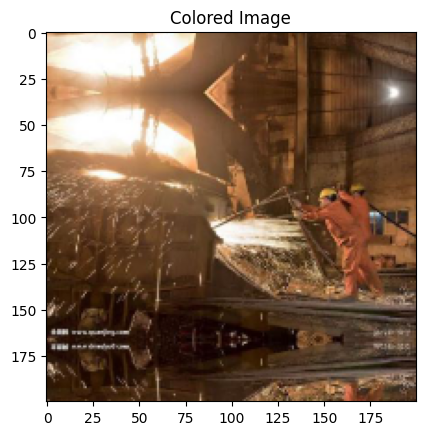

In [ ]:
plt.imshow(images[5]) # Display a grayscale image
plt.title('Colored Image')
plt.show()


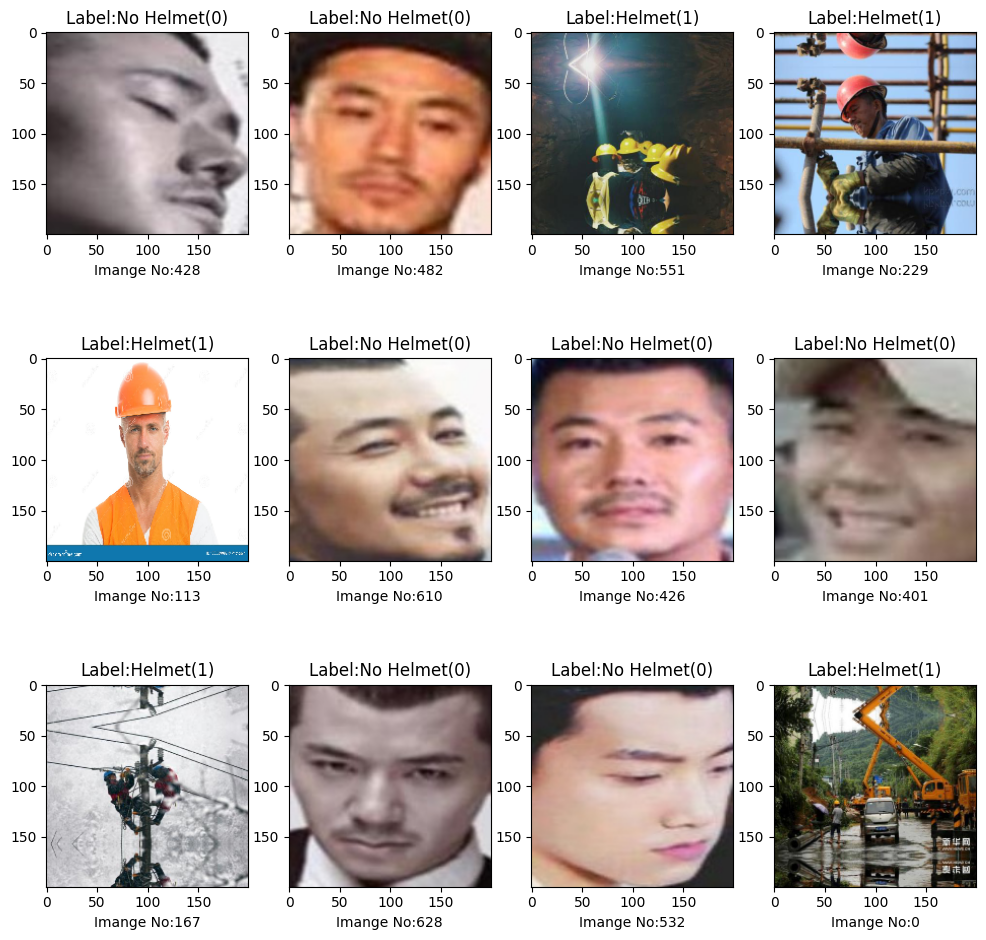

In [ ]:
plot_images(images,labels)

### Observation

* 12 random colored images has been plotted with their labels.

## Converting images to grayscale

image shape before converting to grayscale: (631, 200, 200, 3)
image shape after converting to grayscale: (631, 200, 200, 3)


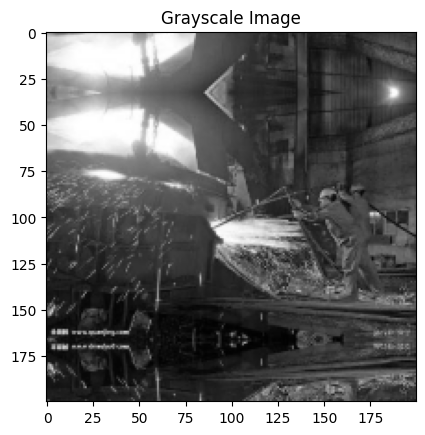

In [ ]:
def Conver2gray(imges, height=None, width=None):
  imges_gray = []
  for img in imges:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # adding RGB channel in the gray image to run vgg
    gray_img_rgb = cv2.merge([gray_img, gray_img, gray_img])
    #print(f'shape:{gray_img_rgb.shape}')
    imges_gray.append(gray_img_rgb)

  if height is not None and width is not None:
    imges_gray = resize_images(imges_gray, width, height)


  return np.array(imges_gray)

# Converting image to grayscale
print(f'image shape before converting to grayscale: {np.array(images).shape}')
images_gray = Conver2gray(images)
print(f'image shape after converting to grayscale: {images_gray.shape}')

plt.imshow(images_gray[5], cmap='gray') # Display a grayscale image
plt.title('Grayscale Image')
plt.show()



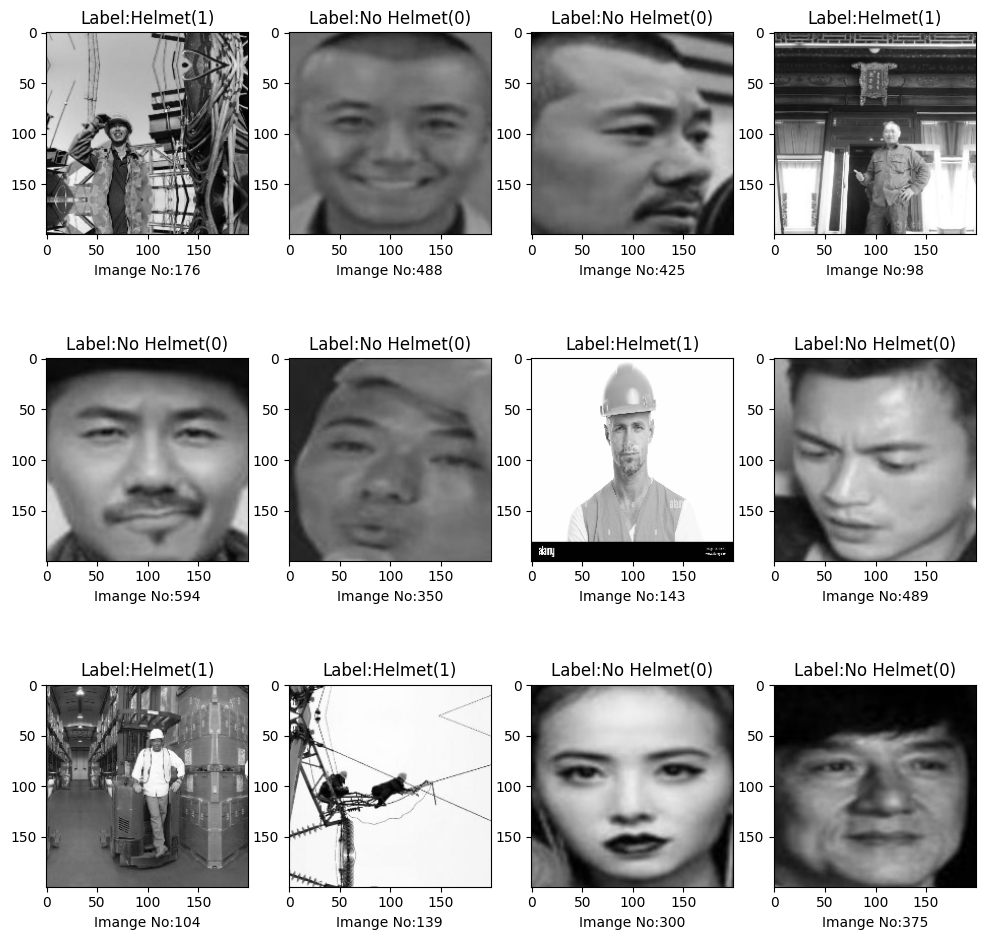

In [ ]:
plot_images(images_gray,labels, cmap='gray')

### Observation

* Gray images has been plotted after converting the images to grayscale

## Resizing Image

In [ ]:
def resize_images(images, width = 64, height=64):
  images_resized = []
  for i in range(len(images)):
    images_resized.append( cv2.resize(images[i], (width, height), interpolation=cv2.INTER_LINEAR))
  resize_image = np.array(images_resized)
  print(f'image shape after rescaling: {resize_image.shape}')
  return resize_image

# We resized image because of lack of GPU to run model in colab
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_CHANNEL=3

dropout_rate = .5

images = resize_images(images, IMAGE_WIDTH, IMAGE_HEIGHT)
images_gray = resize_images(images_gray, IMAGE_WIDTH, IMAGE_HEIGHT)



image shape after rescaling: (631, 64, 64, 3)
image shape after rescaling: (631, 64, 64, 3)


### Images after data preprocessing

#### Colored Picture

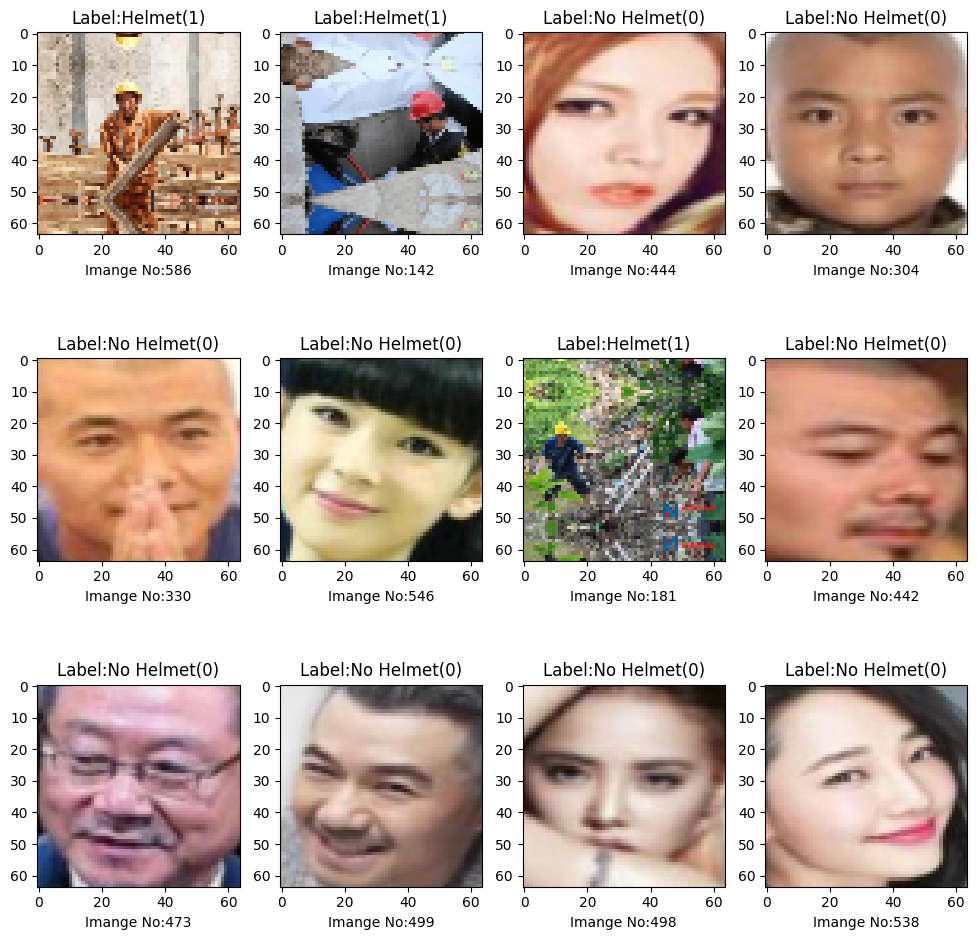

In [ ]:
plot_images(images,labels)

#### Gray colored picture

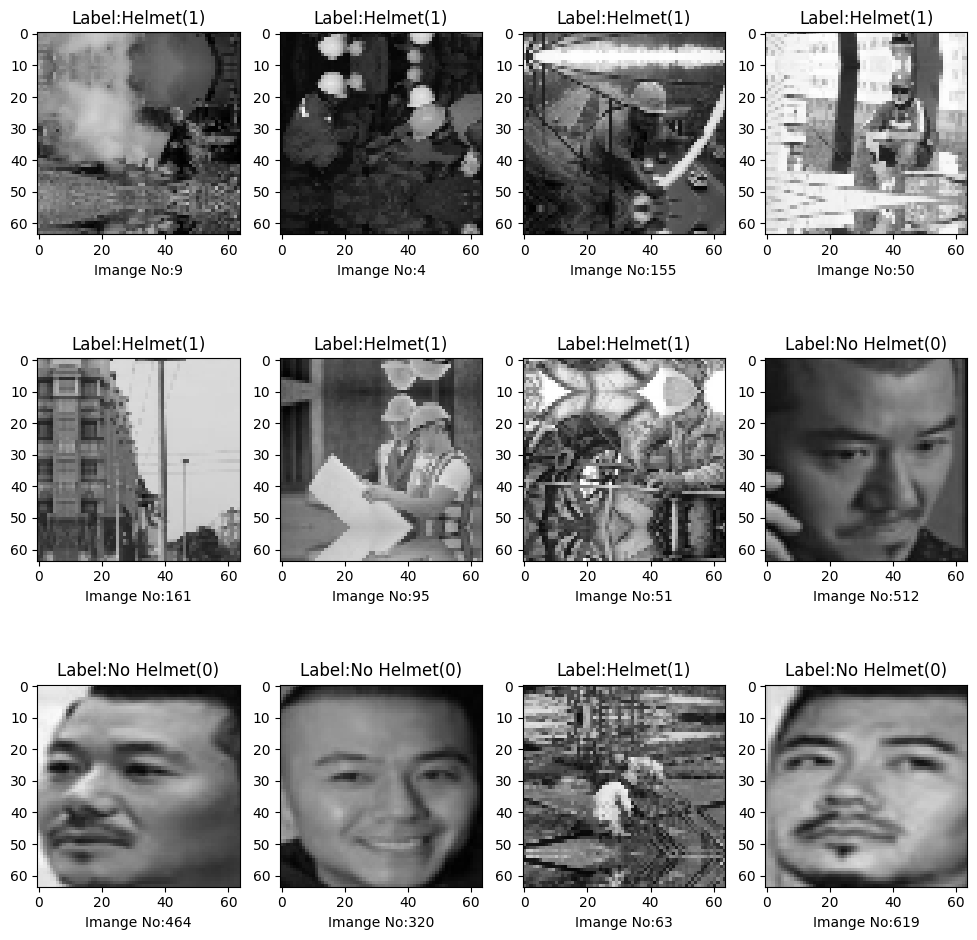

In [ ]:
plot_images(images_gray,labels)

### Observation

* We resize the image dataset to 64 X 64 color (3 channels with RGB) pixel for our model. The downscaling image size impact image quality.
* VGG 16 supports max 220 X 220 pixel and min 32 X 32 pixel. We downscaled our dataset image size to 64 X 64 to run our model with Google Colab free GPU.

### Splitting the dataset



In [ ]:
from sklearn.model_selection import train_test_split

def get_training_validation_testing_data(images, labels):
  X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.30, random_state=42,stratify=labels)
  X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

  print("Training:")
  print(X_train.shape, y_train.shape)
  print("Validation:")
  print(X_val.shape, y_val.shape)
  print("Testing:")
  print(X_test.shape, y_test.shape)

  classes = ['No Helmet 0', 'Helmet 1']
  def get_label_stat(y_label, ds_type):
      y_label = np.array(y_label).flatten()
      for i in range (len(classes)):
          #print(np.array(y_label))
          total = sum(y_label == i)
          #print(total)
          print("After Splitting, {} data set has counts of Helmet = {}: {} with probability {:.2f}%".format(ds_type, i, total, total/len(y_label) * 100))


  get_label_stat(y_train, "Training")
  get_label_stat(y_val, "Validation")
  get_label_stat(y_test, "Testing")

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
print("Spliting dataset to training, validataion, and testing for Color images")
X_train, X_val, X_test, y_train, y_val, y_test = get_training_validation_testing_data(images, labels)

Spliting dataset to training, validataion, and testing for Color images
Training:
(441, 64, 64, 3) (441, 1)
Validation:
(95, 64, 64, 3) (95, 1)
Testing:
(95, 64, 64, 3) (95, 1)
After Splitting, Training data set has counts of Helmet = 0: 224 with probability 50.79%
After Splitting, Training data set has counts of Helmet = 1: 217 with probability 49.21%
After Splitting, Validation data set has counts of Helmet = 0: 48 with probability 50.53%
After Splitting, Validation data set has counts of Helmet = 1: 47 with probability 49.47%
After Splitting, Testing data set has counts of Helmet = 0: 48 with probability 50.53%
After Splitting, Testing data set has counts of Helmet = 1: 47 with probability 49.47%


In [ ]:
print("Spliting dataset to training, validataion, and testing for gray scaled images")
X_train_gray, X_val_gray, X_test_gray, y_train_gray, y_val_gray, y_test_gray = get_training_validation_testing_data(images_gray, labels)

Spliting dataset to training, validataion, and testing for gray scaled images
Training:
(441, 64, 64, 3) (441, 1)
Validation:
(95, 64, 64, 3) (95, 1)
Testing:
(95, 64, 64, 3) (95, 1)
After Splitting, Training data set has counts of Helmet = 0: 224 with probability 50.79%
After Splitting, Training data set has counts of Helmet = 1: 217 with probability 49.21%
After Splitting, Validation data set has counts of Helmet = 0: 48 with probability 50.53%
After Splitting, Validation data set has counts of Helmet = 1: 47 with probability 49.47%
After Splitting, Testing data set has counts of Helmet = 0: 48 with probability 50.53%
After Splitting, Testing data set has counts of Helmet = 1: 47 with probability 49.47%


### Ovservation

* We split the dataset into training, validation, and testing.
* All dataset split has almost the same distributions of the labels.
* Label of image dataset:  
  - **0** represents Image doesn't have a safety helmet.
  - **1** represents Image has safety helmet.

### Data Normalization

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
# Normalizing the Color image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


In [ ]:
# Normalizing the Gray image pixels
X_train_normalized_gray = X_train_gray.astype('float32')/255.0
X_val_normalized_gray = X_val_gray.astype('float32')/255.0
X_test_normalized_gray = X_test_gray.astype('float32')/255.0


# **Model Building**

## Criteria

* Convolution (CNN) layers with filtering, max pooling, and artificial neural network with 3 hidden layer:
  - RELU activation function in CNN, and hidden layer.
  - Drop out - .5 has been applied for few model to compare
  - Adam optimizer
  - batch size = 64, epoc/number of iteration = 10
  - Sigmoid output layer

* VGG-16 model as transfer learning
  - VGG-16 model with freezing its convolution layer, and a sigmoid output layer.
  - VGG-16 convolution layer, and a ANN with a sigmoid output layer.
  - VGG-16 convolution layer with audmentation, and a ANN with a sigmoid output layer.
  - RELU activation function in hidden layer.
  - Drop out - .5 has been applied for few model to compare
  - Adam optimizer
  - batch size = 64, epoc/number of iteration = 10
  - Sigmoid output layer

* We will build models for each of the criteria with both colored and gray images.

##Model Evaluation Criterion

* The model successful predictions as:
  - classifying an image with safety helmet and indeed the image originaly has a helmet. This is known as True Positive (**TP**).
  - classifying an image without safety helmet and indeed the image originaly doesn't have a helmet. This is known as True Negative (**TN**).
  
* The model can make wrong predictions as:

  - classifying an image with safety helmet. However, the image originaly doesn't have a helmet. This is known as False Positive (**FP**).
  - classifying an image without safety helmet. However the image originaly has a helmet. This is known as False Negative (**FN**).

* Which case is more important?

  - The main object is to build a system to classify, safety helment of workers, therefore, FP is important as our objective will be to minimized it as much as possible. Hence, We will use **Recall** to evaluate our models.


* Model evaluation metrics definition:
  - Popular machine learning performance evaluation metrics are:
    - Accuracy, Precision, Recall, and F1-score.

In [ ]:
# results_eval has the cummulative model evaluation metrics
columns_eval_metric = ["model", "Train_Accuracy","Validation_Accuracy", "Train_Recall", "Validation_Recall", "Train_Precission", "Validation_Precission", "Train_F1","Validation_F1"]
results_eval = pd.DataFrame(columns=columns_eval_metric)
results_eval


Empty DataFrame
Columns: [model, Train_Accuracy, Validation_Accuracy, Train_Recall, Validation_Recall, Train_Precission, Validation_Precission, Train_F1, Validation_F1]
Index: []

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
# This function build and return confusion matrix
def get_confusion_matrix(model,predictors,target,  ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    return confusion_matrix

In [ ]:
def plot(history, names):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    i = 0
    fig, ax = plt.subplots(1, len(names), figsize=(20, 6)) #Creating a subplot with figure and axes.
    for name in names:
      ax[i].plot(history.history[name]) #Plotting the train accuracy or train loss
      ax[i].plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

      ax[i].set_title('Model ' + name.capitalize()) #Defining the title of the plot.
      ax[i].set_ylabel(name.capitalize()) #Capitalizing the first letter.
      ax[i].set_xlabel('Epoch') #Defining the label for the x-axis.
      ax[i].legend(['Train', 'Validation']) #Defining the legend, loc controls the position of the legend.
      i += 1
    plt.tight_layout()
    plt.show()

#plot(history,['loss','accuracy', 'recall'])
#plot(history,['loss','accuracy'])


In [ ]:
def show_performance_metrics(history, model_name, model, X_training, y_training, X_validation, y_validation, is_testing = False):
  """
    Function to show performance metrics

    history: an object which stores the metrics and losses.
    model_name: name of the model
    model: model object
    X_training: training data
    y_training: training labels
    X_validation: validation data
    y_validation: validation labels
    is_testing: flag for testing data
    """
  # Plotting loss and accuracy of model
  if is_testing == False:
    plot(history,['loss','accuracy'])

  test_validation = "Test" if is_testing == True else "Validation"

  # get model performance metrics
  model_train_perf = model_performance_classification(model, X_training, y_training)
  model_valid_perf = model_performance_classification(model, X_validation, y_validation)

  # get confusion metrics of training and validation/testing and draw them horizontally
  cm1 = get_confusion_matrix(model, X_training, y_training)
  cm2 = get_confusion_matrix(model, X_validation, y_validation)

  fig, ax =plt.subplots(1,2, figsize=(12, 5))
  classes = ['No Helmet 0', 'Helmet 1']

  sns.heatmap(cm1, xticklabels=classes, yticklabels=classes, annot=True, fmt="", ax=ax[0], cmap="coolwarm")
  ax[0].set_title("Training")

  sns.heatmap(cm2, xticklabels=classes, yticklabels=classes, annot=True, fmt="", ax=ax[1], cmap="winter")
  ax[1].set_title(test_validation)
  plt.show()

  print("Classification Report")
  print(classification_report(y_validation, model.predict(X_validation) > 0.5, target_names=classes))



  model_train_perf_dict = dict((k, v[0]) for k, v in model_train_perf.to_dict(orient='list').items())
  model_valid_perf_dict = dict((k, v[0]) for k, v in model_valid_perf.to_dict(orient='list').items())

  index = results_eval.shape[0]

  #columns_eval_metric = ["model", "Train_Accuracy","Validation_Accuracy", "Train_Recall", "Validation_Recall", "Train_Precission", "Validation_Precission", "Train_F1","Validation_F1"]
  results_eval.loc[index] = [model_name] + [model_train_perf_dict["Accuracy"], model_valid_perf_dict["Accuracy"], model_train_perf_dict["Recall"], model_valid_perf_dict["Recall"], model_train_perf_dict["Precision"], model_valid_perf_dict["Precision"], model_train_perf_dict["F1 Score"], model_valid_perf_dict["F1 Score"]]

  # results_eval is the cummulative model evaluation dataframe
  return results_eval

In [ ]:
def get_binary_output_from_probability(prod):
  return 1 if prod > 0.5 else 0

def show_visulization(X, X_norm, y, model, height, width, channel, index=[0, -1]):
  """
  Function to show images and its prediction with true label.
  X: Image matrix
  X_norm: Normalized Image matrix
  y: true label of image
  mode: model
  height: height of the image used in the model
  width: width of the image used in the model
  channel: channel of the image used in the model
  index: index of the images to be plotted
  """
  for i in index:
    plt.figure(figsize=(2,2))
    plt.imshow(X[i])
    plt.show()
    prob = model.predict(X_norm[i].reshape(1,height,width,channel))[0][0]
    output = get_binary_output_from_probability(prob)
    print(f'Predicted Probability: {prob}, and  Label {output}')
    print('True Label:', np.array(y)[i][0])


##Model 1: Simple Convolutional Neural Network (CNN)

In [ ]:
def get_cnn_color_model(drop_out_rate= None):
  """
  Function to get cnn model
  drop_out_rate: dropout rate to be applied
  """

  # Initializing Model
  model_1 = Sequential()

  if drop_out_rate is not None:
    drop_out = Dropout(rate=drop_out_rate)


  # 3 Convolutional layers with 64 (3 X 3) filters with max pooling (2 X 2)
  model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL))) #Complete the code to define the shape of the input image
  model_1.add(MaxPooling2D((2, 2), padding='same'))

  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Conv2D(64, (3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
  model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel

  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Conv2D(64, (3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
  model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel


  # Flatten and Dense layers
  model_1.add(Flatten())
  model_1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))  #Complete the code to define the number of neurons in the output layer and the activation function
  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

  # Adding a dense output layer
  model_1.add(Dense(1, activation='sigmoid'))


  # Compile with Adam Optimizer
  opt = Adam(learning_rate=.001) #Complete the code to define the learning rate.
  model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","recall"]) #Complete the code to define the metric of choice from Precision,f1_score,Recall

  # Summary
  model_1.summary()

  tf.config.run_functions_eagerly(True)

  history_cnn = model_1.fit(
              X_train_normalized, np.array(y_train),
              epochs=10,
              validation_data=(X_val_normalized, np.array(y_val)),
              batch_size=64,
              shuffle=True,
              verbose=2
  )

  return history_cnn, model_1

def get_cnn_gray_model(drop_out_rate= None):
  """
  Function to get cnn model
  drop_out_rate: dropout rate to be applied
  """

  # Initializing Model
  model_1 = Sequential()

  if drop_out_rate is not None:
    drop_out = Dropout(rate=drop_out_rate)


  # 3 Convolutional layers with 64 (3 X 3) filters with max pooling (2 X 2)
  model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL))) #Complete the code to define the shape of the input image
  model_1.add(MaxPooling2D((2, 2), padding='same'))

  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Conv2D(64, (3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
  model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel

  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Conv2D(64, (3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
  model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel


  # Flatten and Dense layers
  model_1.add(Flatten())
  model_1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))  #Complete the code to define the number of neurons in the output layer and the activation function
  if drop_out_rate is not None:
    model_1.add(drop_out)

  model_1.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

  # Adding a dense output layer
  model_1.add(Dense(1, activation='sigmoid'))


  # Compile with Adam Optimizer
  opt = Adam(learning_rate=.001) #Complete the code to define the learning rate.
  model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","recall"]) #Complete the code to define the metric of choice from Precision,f1_score,Recall

  # Summary
  model_1.summary()

  tf.config.run_functions_eagerly(True)

  history_cnn = model_1.fit(
              X_train_normalized_gray, np.array(y_train_gray),
              epochs=10,
              validation_data=(X_val_normalized_gray, np.array(y_val_gray)),
              batch_size=64,
              shuffle=True,
              verbose=2
  )

  return history_cnn, model_1

def get_cnn_model(drop_out_rate= None):
  history_cnn, model_1 = get_cnn_color_model(drop_out_rate)
  history_cnn_gray, model_1_gray = get_cnn_gray_model(drop_out_rate)
  return history_cnn, model_1, history_cnn_gray, model_1_gray



In [ ]:
nested_dict = {}
history_cnn, model_1, history_cnn_gray, model_1_gray = get_cnn_model()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,697 (4.45 MB)

 Trainable params: 1,165,697 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 - 1s - 129ms/step - accuracy: 0.6417 - loss: 0.6300 - recall: 0.5622 - val_accuracy: 0.8737 - val_loss: 0.4037 - val_recall: 0.9787
Epoch 2/10
7/7 - 1s - 114ms/step - accuracy: 0.9252 - loss: 0.2478 - recall: 0.9263 - val_accuracy: 0.9789 - val_loss: 0.1386 - val_recall: 0.9787
Epoch 3/10
7/7 - 1s - 115ms/step - accuracy: 0.9433 - loss: 0.1403 - recall: 0.9401 - val_accuracy: 0.8211 - val_loss: 0.5138 - val_recall: 1.0000
Epoch 4/10
7/7 - 1s - 113ms/step - accuracy: 0.9478 - loss: 0.1316 - recall: 0.9585 - val_accuracy: 0.9579 - val_loss: 0.1666 - val_recall: 0.9787
Epoch 5/10
7/7 - 1s - 117ms/step - accuracy: 0.9773 - loss: 0.0566 - recall: 0.9908 - val_accuracy: 0.9789 - val_loss: 0.1297 - val_recall: 0.9787
Epoch 6/10
7/7 - 1s - 120ms/step - accuracy: 0.9819 - loss: 0.0520 - recall: 0.9816 - val_accuracy: 0.9789 - val_loss: 0.1190 - val_recall: 0.9787
Epoch 7/10
7/7 - 1s - 119ms/step - accuracy: 0.9887 - loss: 0.0338 - recall: 0.9816 - val_accuracy: 0.9789 - val_loss:

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,697 (4.45 MB)

 Trainable params: 1,165,697 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 - 1s - 127ms/step - accuracy: 0.6259 - loss: 0.6471 - recall: 0.6820 - val_accuracy: 0.5474 - val_loss: 0.6389 - val_recall: 0.0851
Epoch 2/10
7/7 - 1s - 116ms/step - accuracy: 0.8209 - loss: 0.4571 - recall: 0.7512 - val_accuracy: 0.9895 - val_loss: 0.2235 - val_recall: 1.0000
Epoch 3/10
7/7 - 1s - 115ms/step - accuracy: 0.9751 - loss: 0.1230 - recall: 0.9724 - val_accuracy: 0.9789 - val_loss: 0.1339 - val_recall: 0.9787
Epoch 4/10
7/7 - 1s - 114ms/step - accuracy: 0.9841 - loss: 0.0339 - recall: 0.9816 - val_accuracy: 0.9789 - val_loss: 0.1893 - val_recall: 0.9787
Epoch 5/10
7/7 - 1s - 115ms/step - accuracy: 0.9841 - loss: 0.0301 - recall: 0.9770 - val_accuracy: 0.6842 - val_loss: 1.7011 - val_recall: 1.0000
Epoch 6/10
7/7 - 1s - 116ms/step - accuracy: 0.8957 - loss: 0.5022 - recall: 0.8848 - val_accuracy: 0.8421 - val_loss: 0.5047 - val_recall: 1.0000
Epoch 7/10
7/7 - 1s - 115ms/step - accuracy: 0.9592 - loss: 0.1132 - recall: 0.9954 - val_accuracy: 0.9474 - val_loss:

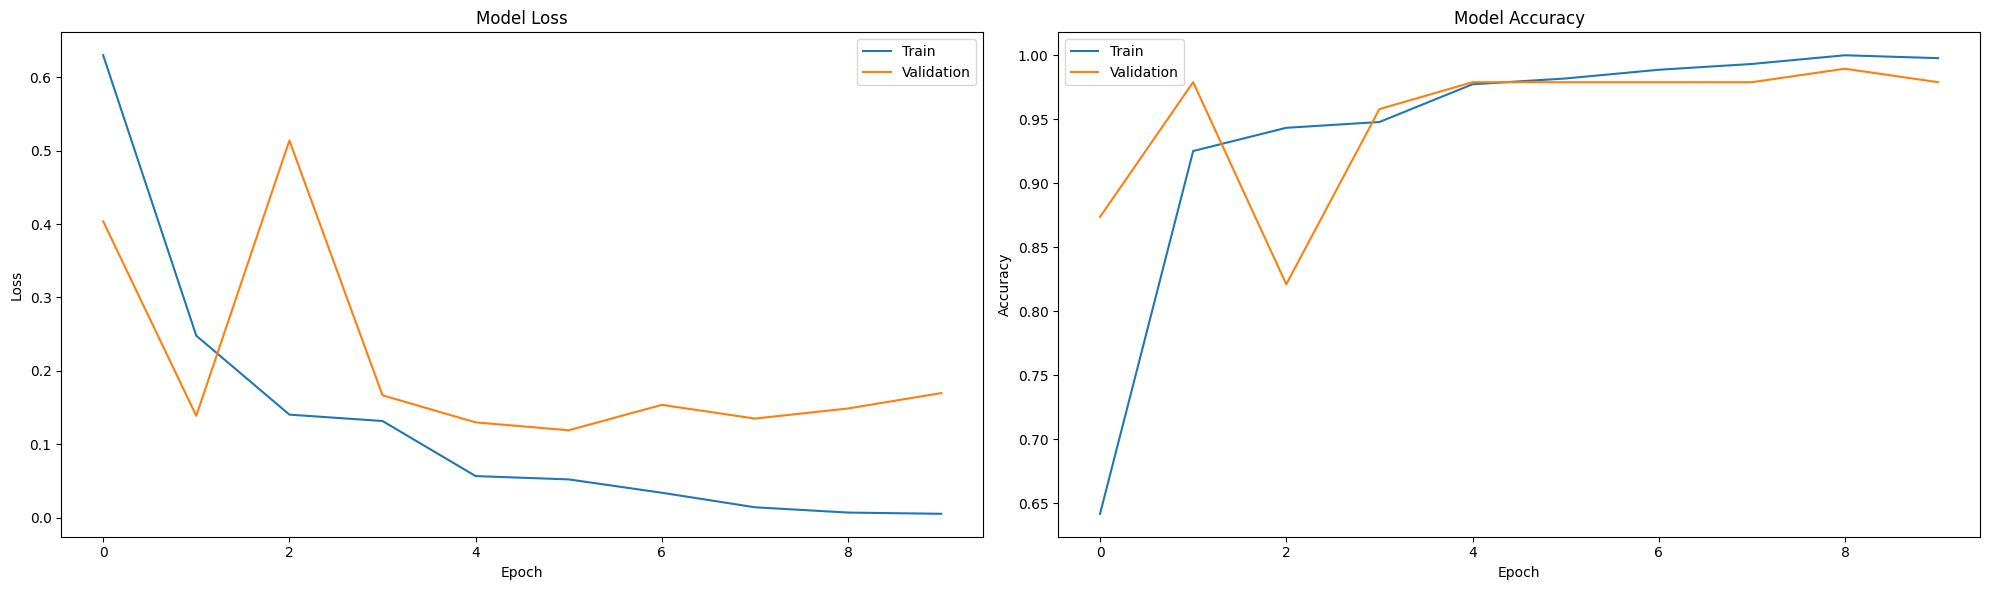

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


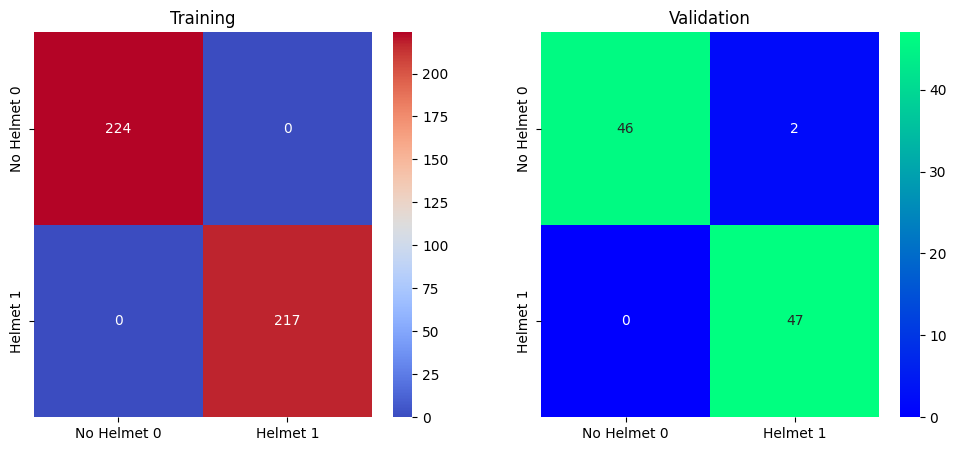

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.96      0.98        48
    Helmet 1       0.96      1.00      0.98        47

    accuracy                           0.98        95
   macro avg       0.98      0.98      0.98        95
weighted avg       0.98      0.98      0.98        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  Validation_Recall  \
0   CNN             1.0             0.978947           1.0           0.978947   

   Train_Precission  Validation_Precission  Train_F1  Validation_F1  
0               1.0               0.979807       1.0       0.978943

In [ ]:
show_performance_metrics(history_cnn, 'CNN', model_1, X_train_normalized, y_train, X_val_normalized, y_val)

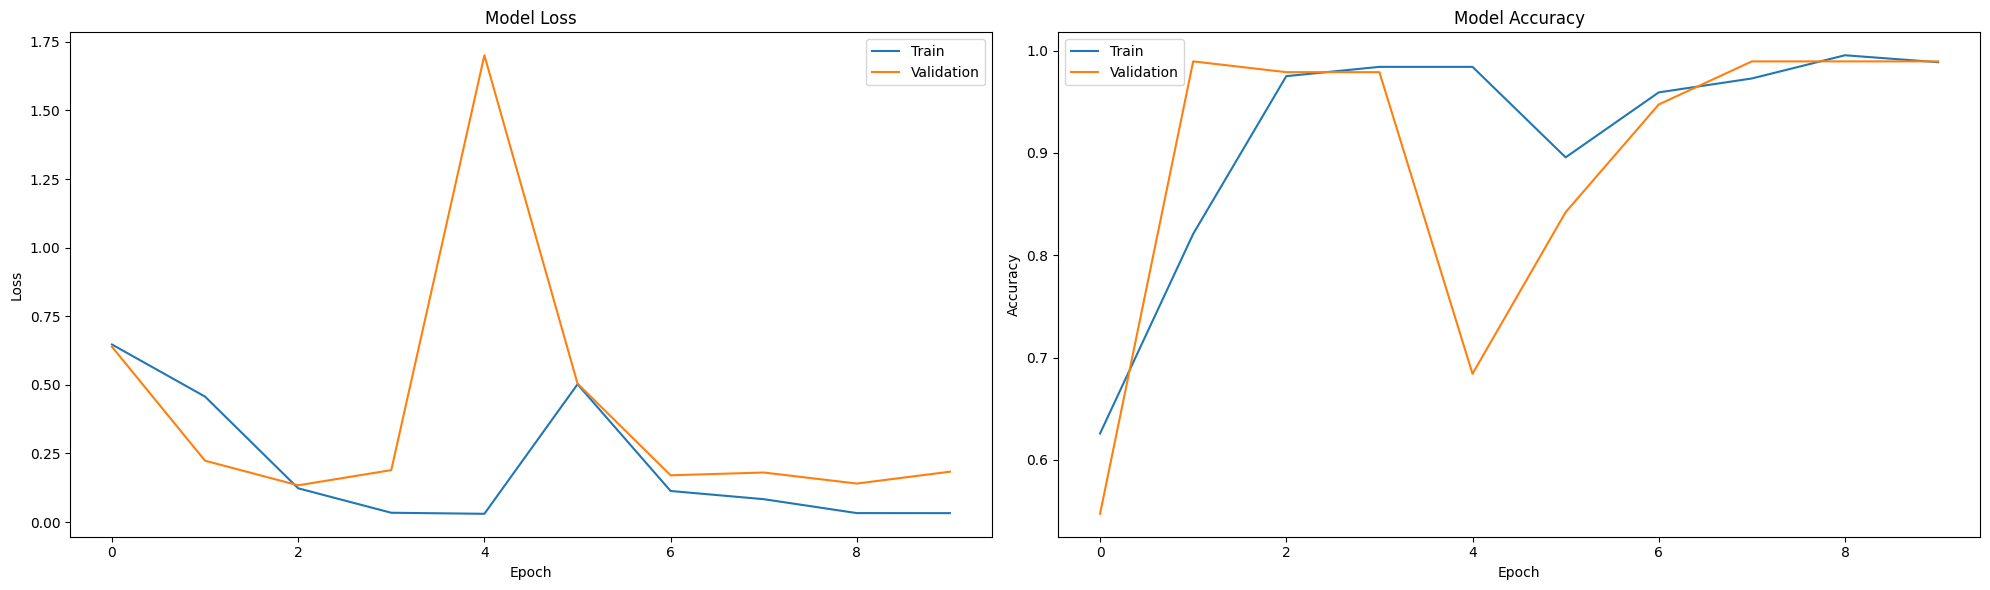

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


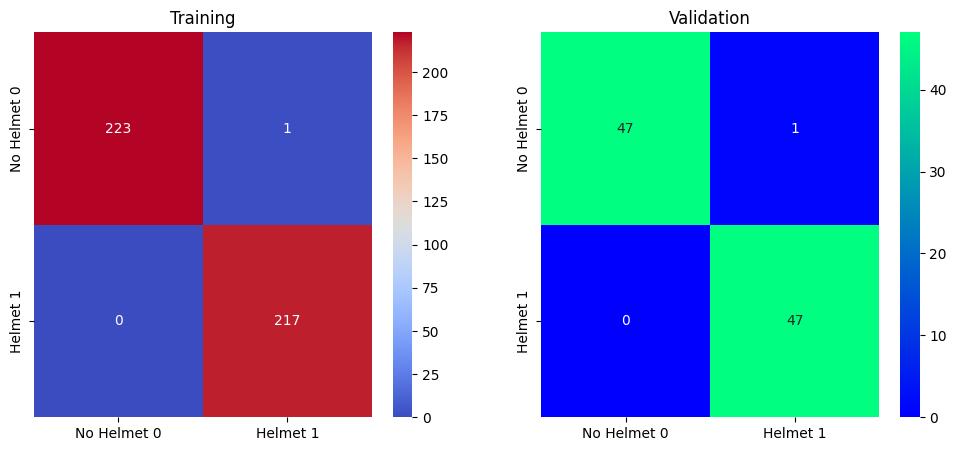

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0        CNN        1.000000             0.978947      1.000000   
1  CNN:Grapy        0.997732             0.989474      0.997732   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   

   Validation_F1  
0       0.978943  
1       0.989474

In [ ]:
show_performance_metrics(history_cnn_gray, 'CNN:Grapy', model_1_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

### Vizualizing the predictions

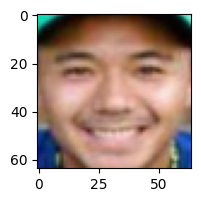

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Probability: 1.8098637156072073e-05, and  Label 0
True Label: 0


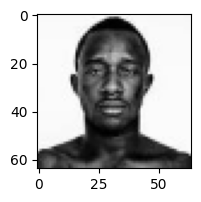

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Probability: 0.9999996423721313, and  Label 1
True Label: 0


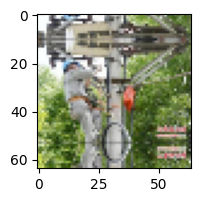

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Probability: 1.0, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

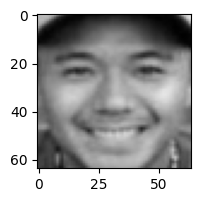

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Probability: 0.0020348140969872475, and  Label 0
True Label: 0


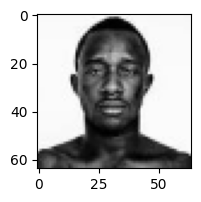

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Probability: 0.9999998807907104, and  Label 1
True Label: 0


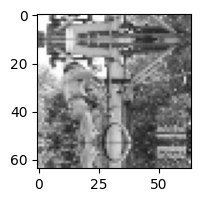

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Probability: 1.0, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_1_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

### Observation

* Our initial model uses 3 convolution layers 64 filters (3X3), and max pooling (2X2), with padding.
* It uses relu activation function.
* Later it uses 3 hidden neural network with binary output later.
* Output of the convolution layers have been flatten and feed to the final neural network.
* We found that CNN model with color images has very good accuracy, recall, precission, F1 against training, almost 100% and validation, almost 98%.
* We found that CNN model with gray images has very good accuracy, recall, precission, F1 against training, almost 99.7% and validation, almost 99%.
* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

### Model CNN with Dropout

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,697 (4.45 MB)

 Trainable params: 1,165,697 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 - 1s - 146ms/step - accuracy: 0.5556 - loss: 0.7328 - recall: 0.5069 - val_accuracy: 0.4947 - val_loss: 0.6880 - val_recall: 1.0000
Epoch 2/10
7/7 - 1s - 133ms/step - accuracy: 0.5329 - loss: 0.6972 - recall: 0.7189 - val_accuracy: 0.8526 - val_loss: 0.6869 - val_recall: 0.9787
Epoch 3/10
7/7 - 1s - 131ms/step - accuracy: 0.5533 - loss: 0.6685 - recall: 0.7742 - val_accuracy: 0.8842 - val_loss: 0.6728 - val_recall: 0.9574
Epoch 4/10
7/7 - 1s - 133ms/step - accuracy: 0.6395 - loss: 0.5962 - recall: 0.9816 - val_accuracy: 0.9053 - val_loss: 0.5851 - val_recall: 0.9574
Epoch 5/10
7/7 - 1s - 133ms/step - accuracy: 0.8617 - loss: 0.4192 - recall: 0.9447 - val_accuracy: 0.9474 - val_loss: 0.2986 - val_recall: 0.9574
Epoch 6/10
7/7 - 1s - 131ms/step - accuracy: 0.9365 - loss: 0.1876 - recall: 0.9263 - val_accuracy: 0.9789 - val_loss: 0.1297 - val_recall: 0.9787
Epoch 7/10
7/7 - 1s - 133ms/step - accuracy: 0.9410 - loss: 0.1706 - recall: 0.9401 - val_accuracy: 0.9579 - val_loss:

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,697 (4.45 MB)

 Trainable params: 1,165,697 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 - 1s - 150ms/step - accuracy: 0.4830 - loss: 0.7484 - recall: 0.5115 - val_accuracy: 0.7684 - val_loss: 0.6884 - val_recall: 0.8511
Epoch 2/10
7/7 - 1s - 134ms/step - accuracy: 0.5261 - loss: 0.6825 - recall: 0.6544 - val_accuracy: 0.5158 - val_loss: 0.6886 - val_recall: 0.0213
Epoch 3/10
7/7 - 1s - 135ms/step - accuracy: 0.5805 - loss: 0.6688 - recall: 0.6728 - val_accuracy: 0.8526 - val_loss: 0.6811 - val_recall: 0.8085
Epoch 4/10
7/7 - 1s - 136ms/step - accuracy: 0.5986 - loss: 0.6533 - recall: 0.8479 - val_accuracy: 0.9053 - val_loss: 0.6618 - val_recall: 0.8298
Epoch 5/10
7/7 - 1s - 135ms/step - accuracy: 0.6780 - loss: 0.5988 - recall: 0.8710 - val_accuracy: 0.9579 - val_loss: 0.5503 - val_recall: 0.9362
Epoch 6/10
7/7 - 1s - 132ms/step - accuracy: 0.8503 - loss: 0.4117 - recall: 0.9309 - val_accuracy: 0.8947 - val_loss: 0.3504 - val_recall: 0.8085
Epoch 7/10
7/7 - 1s - 133ms/step - accuracy: 0.8753 - loss: 0.3082 - recall: 0.8295 - val_accuracy: 0.9789 - val_loss:

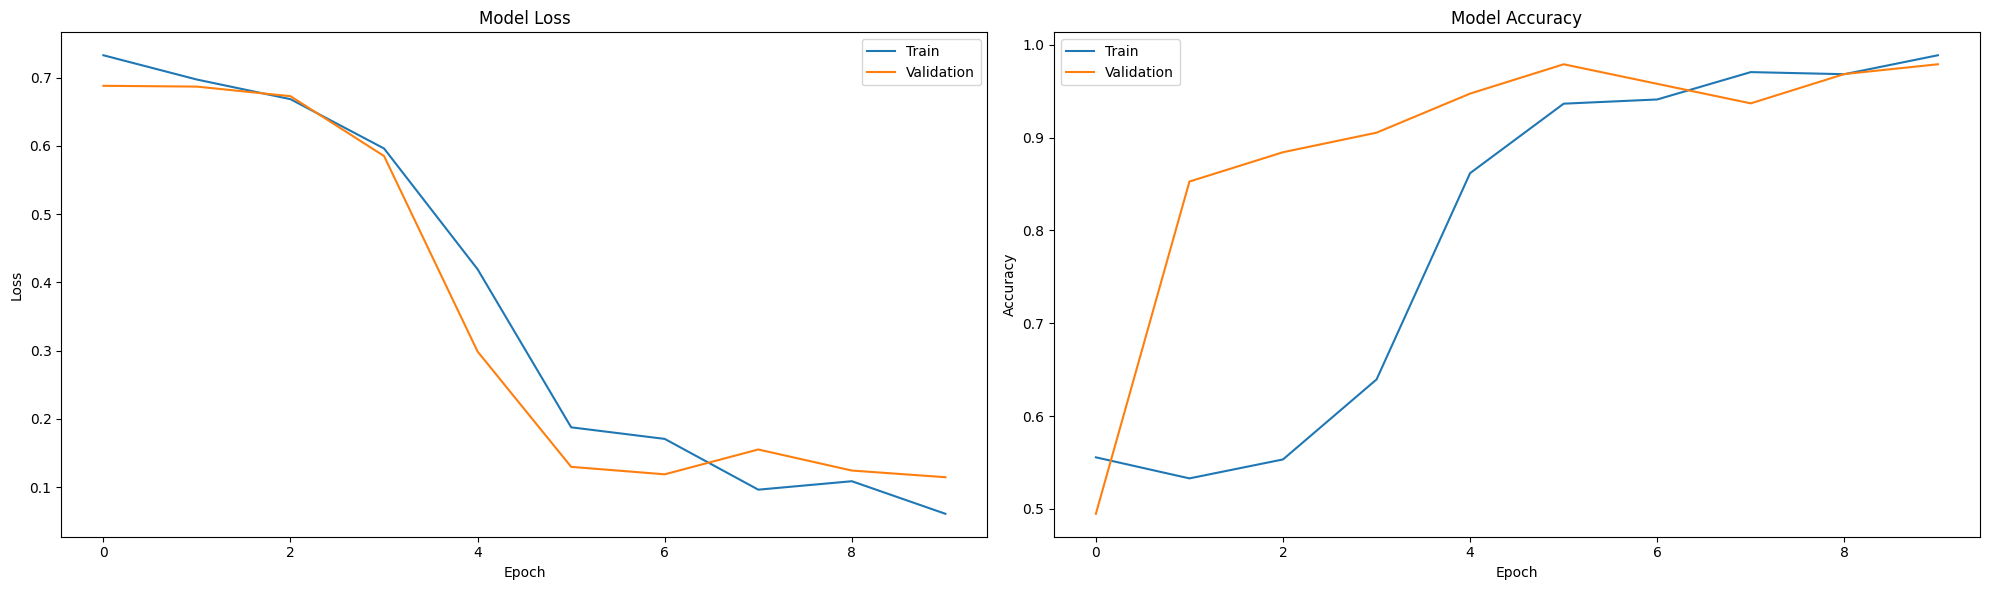

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


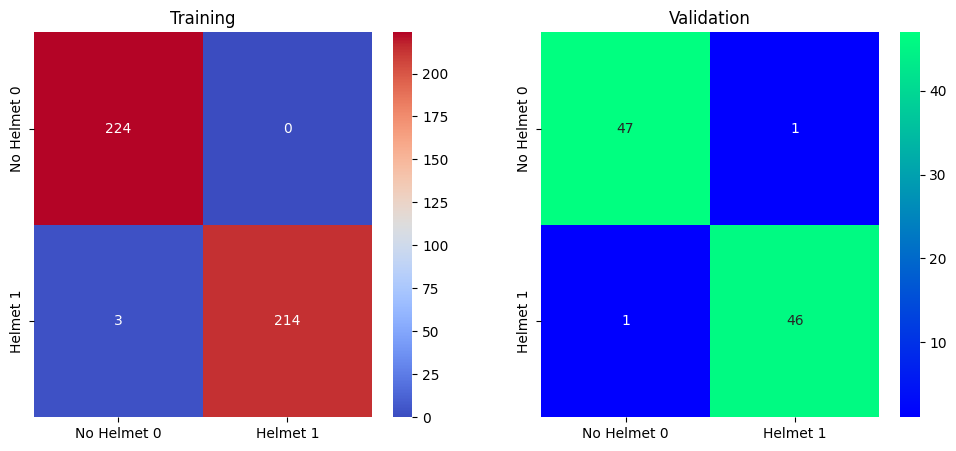

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

 No Helmet 0       0.98      0.98      0.98        48
    Helmet 1       0.98      0.98      0.98        47

    accuracy                           0.98        95
   macro avg       0.98      0.98      0.98        95
weighted avg       0.98      0.98      0.98        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0            CNN        1.000000             0.978947      1.000000   
1      CNN:Grapy        0.997732             0.989474      0.997732   
2  CNN (Drop=.5)        0.993197             0.978947      0.993197   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947

In [ ]:
history_cnn_drop, model_1_1, history_cnn_drop_gray, model_1_1_gray = get_cnn_model(drop_out_rate= dropout_rate)
show_performance_metrics(history_cnn_drop, 'CNN (Drop=.5)', model_1_1, X_train_normalized, y_train, X_val_normalized, y_val)

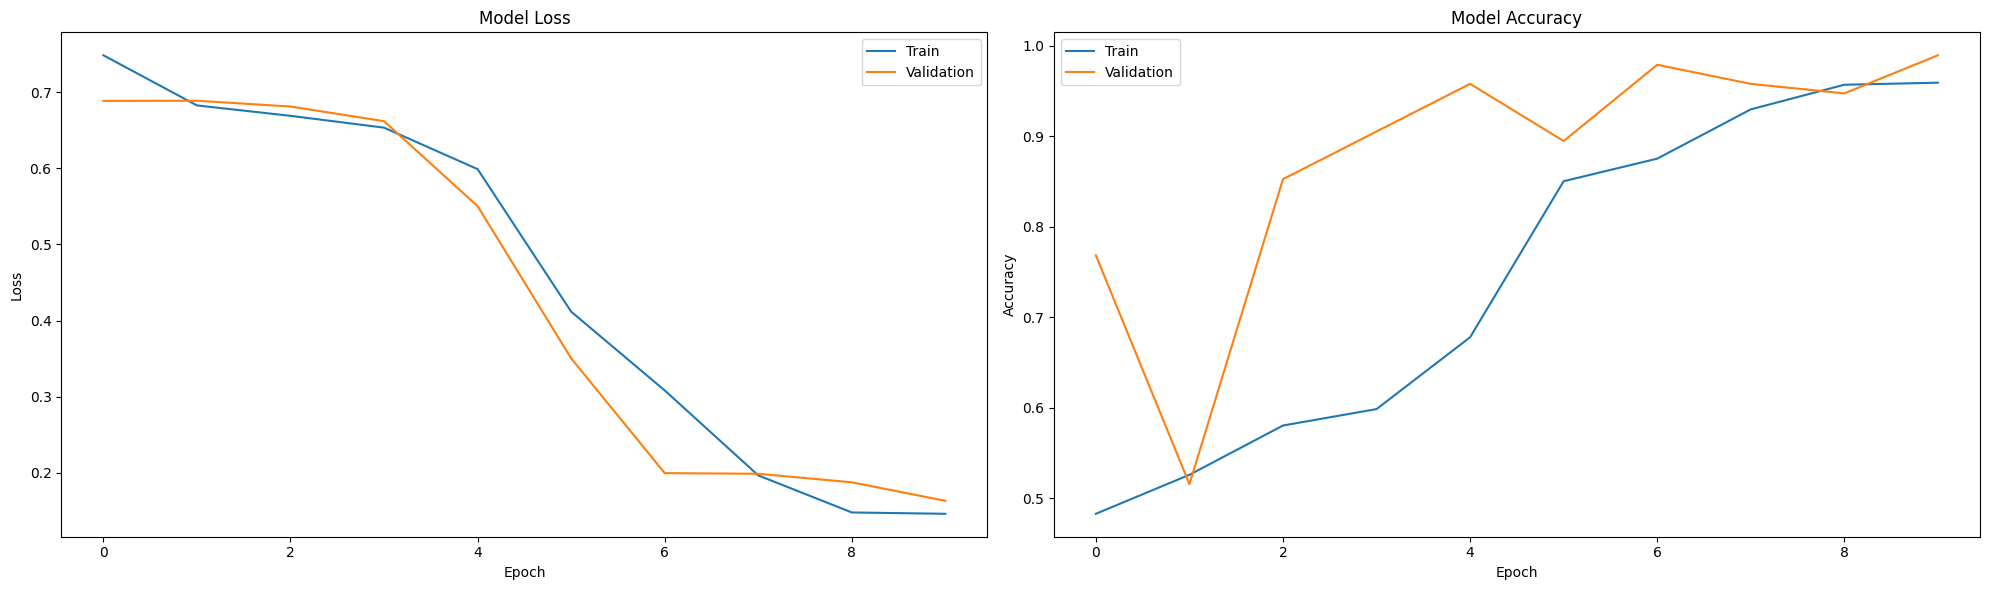

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


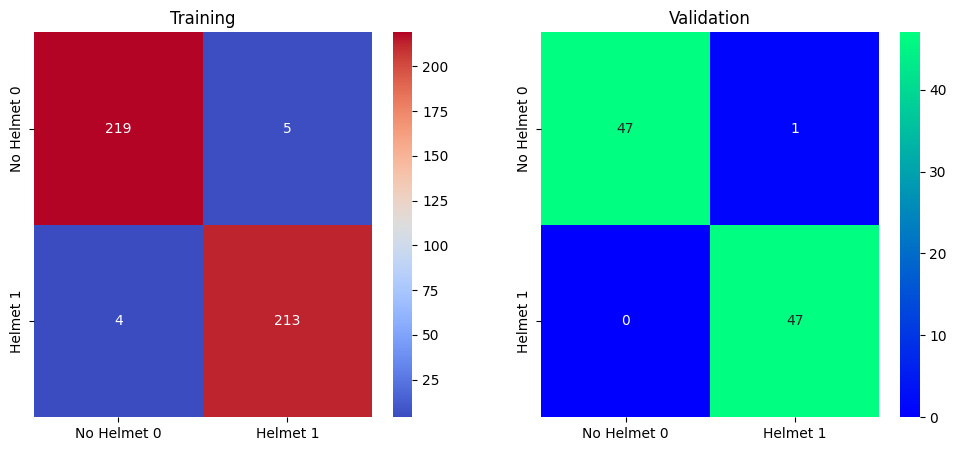

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474

In [ ]:
show_performance_metrics(history_cnn_drop_gray, 'CNN (Drop=.5): Gray', model_1_1_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

### Vizualizing the predictions

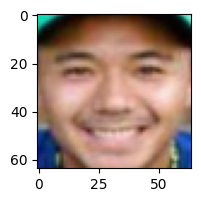

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Probability: 0.01702054589986801, and  Label 0
True Label: 0


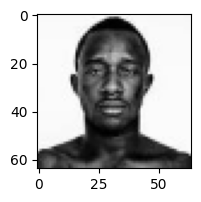

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Probability: 0.9909351468086243, and  Label 1
True Label: 0


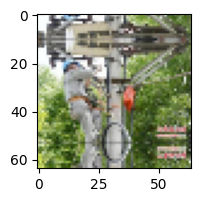

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Probability: 0.999834418296814, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_1_1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

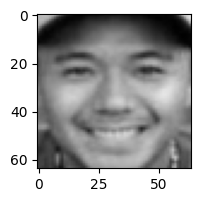

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Probability: 0.08309952169656754, and  Label 0
True Label: 0


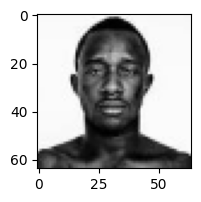

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Probability: 0.9992927312850952, and  Label 1
True Label: 0


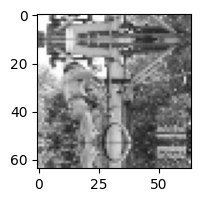

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Probability: 0.9999877214431763, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_1_1_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

### Observation

* Our initial model uses 3 convolution layers 64 filters (3X3), and max pooling (2X2), with padding.
* It uses relu activation function.
* Later it uses 3 hidden neural network with binary output later.
* Output of the convolution layers have been flatten and feed to the final neural network.
* We added 50% drop out in both CNN and neural network
* We found that CNN color image model with drop out of 50% has very good accuracy and recall against training, almost 99% and validation, almost 97.8%.
* We found that CNN gray image model with drop out of 50% has very good accuracy and recall against training, almost 98% and validation, almost 99%.
* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

## Model 2: (VGG-16 (Base))

* We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

* For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten and a single dense layer.

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNEL))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def get_vgg_color_model(only_base=True, train_datagen = ImageDataGenerator(), drop_out_rate = None):
  # Making all the layers of the VGG model non-trainable. i.e. freezing them
  for layer in vgg_model.layers:
      layer.trainable = False

  if drop_out_rate is not None:
    drop_out = Dropout(rate=drop_out_rate)

  model_2 = Sequential()

  # Adding the convolutional part of the VGG16 model from above
  model_2.add(vgg_model)

  # Flattening the output of the VGG16 model because it is from a convolutional layer
  model_2.add(Flatten())

  if only_base == False:
    # Adding a dense output layer
    model_2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    if drop_out_rate is not None:
      model_2.add(drop_out)

    model_2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    if drop_out_rate is not None:
      model_2.add(drop_out)

  # Adding a dense output layer
  model_2.add(Dense(1, activation='sigmoid'))

  opt=Adam()
  # Compile model
  # Other metrics like precision,f1_score,recall can be used
  model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'recall'])


  # Generating the summary of the model
  model_2.summary()

  #train_datagen = ImageDataGenerator()

  # Epochs
  epochs = 10
  # Batch size
  batch_size = 64

  history_vgg16 = model_2.fit(train_datagen.flow(X_train_normalized, y_train,
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=True),
                      epochs=epochs,
                      steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                      validation_data=(X_val_normalized, y_val),
                      verbose=1)

  return history_vgg16, model_2


def get_vgg_gray_model(only_base=True, train_datagen = ImageDataGenerator(), drop_out_rate = None):
  # Making all the layers of the VGG model non-trainable. i.e. freezing them
  for layer in vgg_model.layers:
      layer.trainable = False

  if drop_out_rate is not None:
    drop_out = Dropout(rate=drop_out_rate)

  model_2 = Sequential()

  # Adding the convolutional part of the VGG16 model from above
  model_2.add(vgg_model)

  # Flattening the output of the VGG16 model because it is from a convolutional layer
  model_2.add(Flatten())

  if only_base == False:
    # Adding a dense output layer
    model_2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    if drop_out_rate is not None:
      model_2.add(drop_out)

    model_2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    if drop_out_rate is not None:
      model_2.add(drop_out)

  # Adding a dense output layer
  model_2.add(Dense(1, activation='sigmoid'))

  opt=Adam()
  # Compile model
  # Other metrics like precision,f1_score,recall can be used
  model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'recall'])


  # Generating the summary of the model
  model_2.summary()

  #train_datagen = ImageDataGenerator()

  # Epochs
  epochs = 10
  # Batch size
  batch_size = 64

  tf.config.run_functions_eagerly(True)

  history_vgg16 = model_2.fit(train_datagen.flow(X_train_normalized_gray, y_train_gray,
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=True),
                      epochs=epochs,
                      steps_per_epoch=X_train_normalized_gray.shape[0] // batch_size,
                      validation_data=(X_val_normalized_gray, y_val_gray),
                      verbose=1)




  return history_vgg16, model_2

def get_vgg_model(only_base=True, train_datagen = ImageDataGenerator(), drop_out_rate = None):
  history_vgg16, model_2 = get_vgg_color_model(only_base, train_datagen, drop_out_rate)
  history_vgg16_gray, model_2_gray = get_vgg_gray_model(only_base, train_datagen, drop_out_rate)
  return history_vgg16, model_2, history_vgg16_gray, model_2_gray


In [ ]:
# Getting the base vgg 16 model
history_vgg16_base, model_vgg_base, history_vgg16_base_gray, model_vgg_base_gray = get_vgg_model(only_base=True)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,737 (56.14 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5551 - loss: 0.7327 - recall: 1.0000 - val_accuracy: 0.9053 - val_loss: 0.4571 - val_recall: 0.8511
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9375 - loss: 0.4376 - recall: 0.9706 - val_accuracy: 0.9053 - val_loss: 0.4351 - val_recall: 0.8298
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9416 - loss: 0.3885 - recall: 0.8864 - val_accuracy: 0.9158 - val_loss: 0.3219 - val_recall: 0.8298
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9474 - loss: 0.2518 - recall: 0.8500 - val_accuracy: 0.9368 - val_loss: 0.3011 - val_recall: 0.8723
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9810 - loss: 0.2524 - recall: 0.9641 - val_accuracy: 0.9789 - val_loss: 0.2009 - val_recall: 0.9787
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9844 - loss: 0.1873 - recall: 0.9688 - val_accuracy: 0.9895 - val_loss: 0.1904 - val_recall: 1.0000
Epoch 7/10
6/6 ━━━━

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,737 (56.14 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6164 - loss: 0.6766 - recall: 0.8440 - val_accuracy: 0.9053 - val_loss: 0.5090 - val_recall: 0.8511
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9062 - loss: 0.4821 - recall: 0.8571 - val_accuracy: 0.9368 - val_loss: 0.4754 - val_recall: 0.9149
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9188 - loss: 0.4283 - recall: 0.8741 - val_accuracy: 0.9684 - val_loss: 0.3214 - val_recall: 0.9574
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.3081 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.3023 - val_recall: 0.9787
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9945 - loss: 0.2532 - recall: 0.9924 - val_accuracy: 0.9789 - val_loss: 0.2167 - val_recall: 0.9787
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9844 - loss: 0.2084 - recall: 0.9706 - val_accuracy: 0.9684 - val_loss: 0.2063 - val_recall: 0.9574
Epoch 7/10
6/6 ━━━━

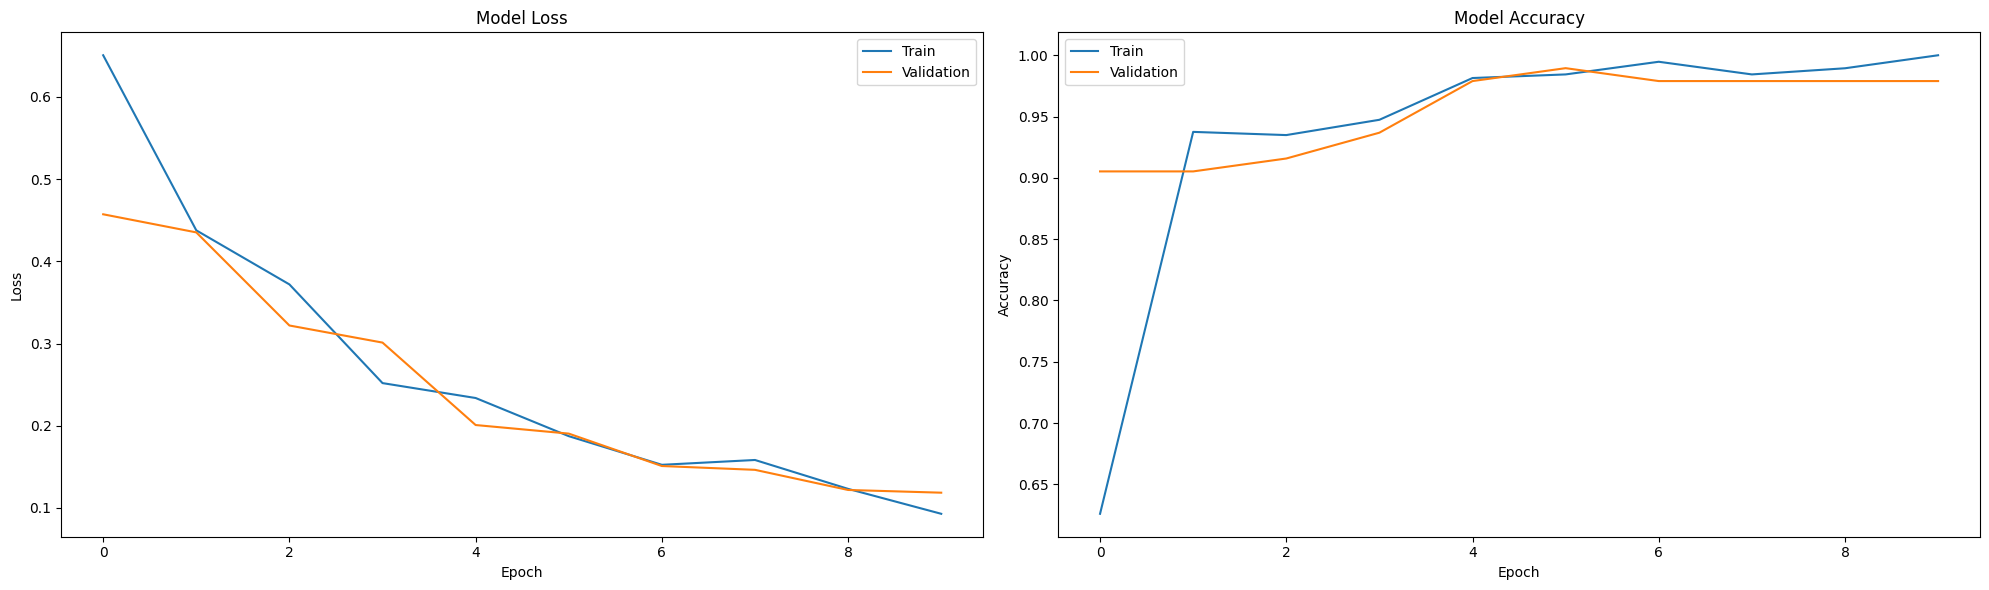

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


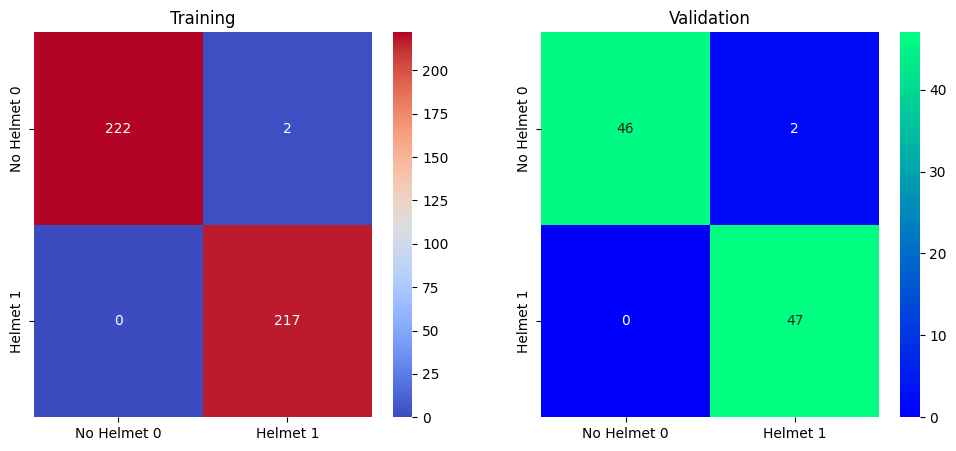

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.96      0.98        48
    Helmet 1       0.96      1.00      0.98        47

    accuracy                           0.98        95
   macro avg       0.98      0.98      0.98        95
weighted avg       0.98      0.98      0.98        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943

In [ ]:
show_performance_metrics(history_vgg16_base, 'VGG_Base', model_vgg_base, X_train_normalized, y_train, X_val_normalized, y_val)

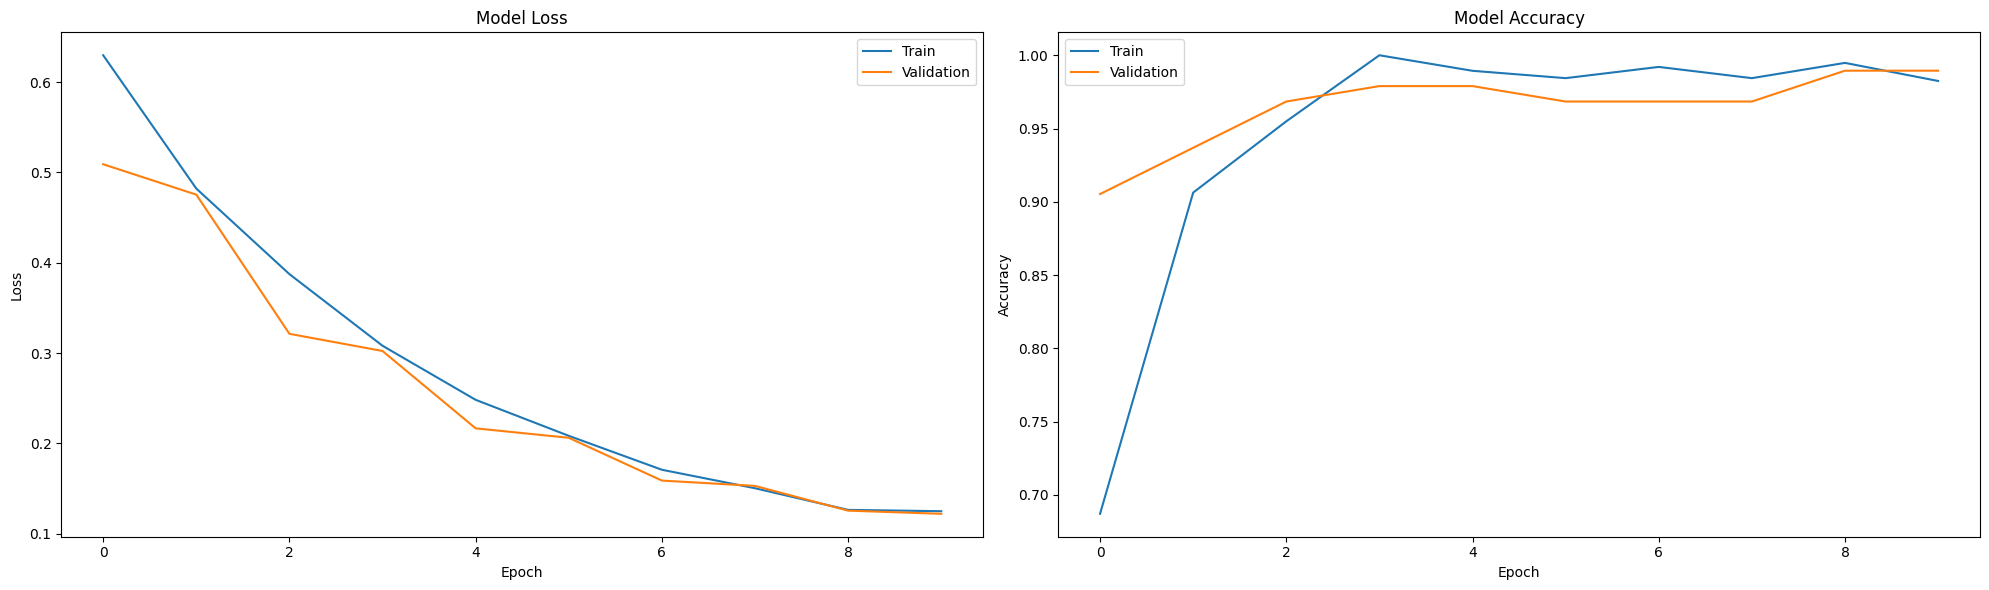

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


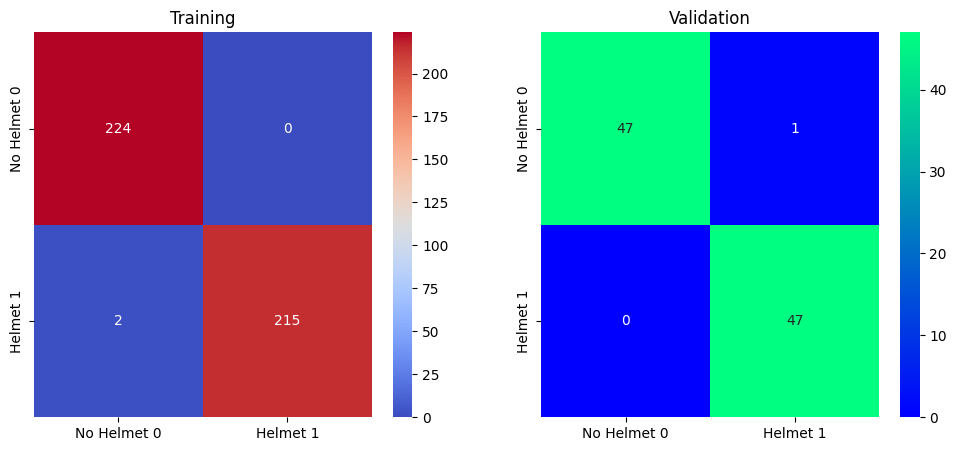

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   
5       VGG_Base: Gray        0.995465             0.989474      0.995465   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   
5           0.989474          0.995505               0.989693  0.995464   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943  
5       0.989474

In [ ]:
show_performance_metrics(history_vgg16_base_gray, 'VGG_Base: Gray', model_vgg_base_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

### Visualizing the prediction:

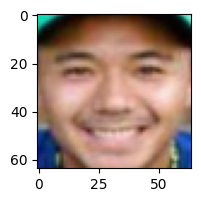

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Probability: 0.1277976781129837, and  Label 0
True Label: 0


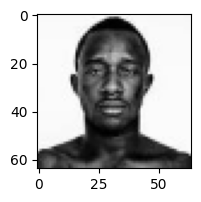

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probability: 0.576281726360321, and  Label 1
True Label: 0


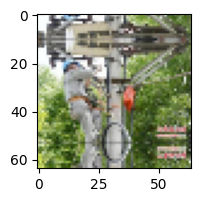

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Probability: 0.972450852394104, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_vgg_base, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

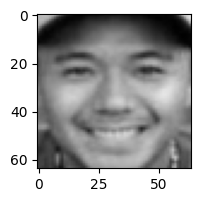

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probability: 0.1768014132976532, and  Label 0
True Label: 0


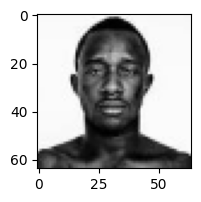

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Probability: 0.6251361966133118, and  Label 1
True Label: 0


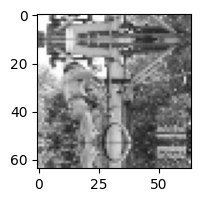

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probability: 0.9549097418785095, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_vgg_base_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

### Observation

* We freeze VGG 16 convolution layers and feed it to an output layer.
* We found that VGG base color image model has very good accuracy and recall against training (99.5%) and validation, almost 97.8%.
* We found that VGG base gray image model has very good accuracy and recall against training (99.5%) and validation, almost 99%.

* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

## Model 3: (VGG-16 (Base + FFNN))

In [ ]:
# Getting the base vgg 16 model with FFNN
history_vgg16_ffnn, model_vgg_ffnn, history_vgg16_ffnn_gray, model_vgg_ffnn_gray = get_vgg_model(only_base=False)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8051 - loss: 0.3897 - recall: 0.9520 - val_accuracy: 0.9789 - val_loss: 0.0412 - val_recall: 0.9574
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9844 - loss: 0.0300 - recall: 0.9667 - val_accuracy: 0.9895 - val_loss: 0.0309 - val_recall: 1.0000
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9964 - loss: 0.0114 - recall: 0.9927 - val_accuracy: 0.9789 - val_loss: 0.0490 - val_recall: 1.0000
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0025 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.0450 - val_recall: 1.0000
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0029 - recall: 1.0000 - val_accuracy: 0.9895 - val_loss: 0.0127 - val_recall: 1.0000
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.9395e-04 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0114 - val_recall: 1.0000
Epoch 7/10
6/6 

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6641 - loss: 0.4582 - recall: 0.6952 - val_accuracy: 0.9789 - val_loss: 0.0609 - val_recall: 0.9574
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9688 - loss: 0.0799 - recall: 0.9429 - val_accuracy: 0.9789 - val_loss: 0.0415 - val_recall: 1.0000
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9928 - loss: 0.0243 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.0313 - val_recall: 1.0000
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0035 - recall: 1.0000 - val_accuracy: 0.9895 - val_loss: 0.0261 - val_recall: 1.0000
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9988 - loss: 0.0055 - recall: 0.9975 - val_accuracy: 0.9895 - val_loss: 0.0192 - val_recall: 1.0000
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0013 - recall: 1.0000 - val_accuracy: 0.9895 - val_loss: 0.0200 - val_recall: 1.0000
Epoch 7/10
6/6 ━━━━

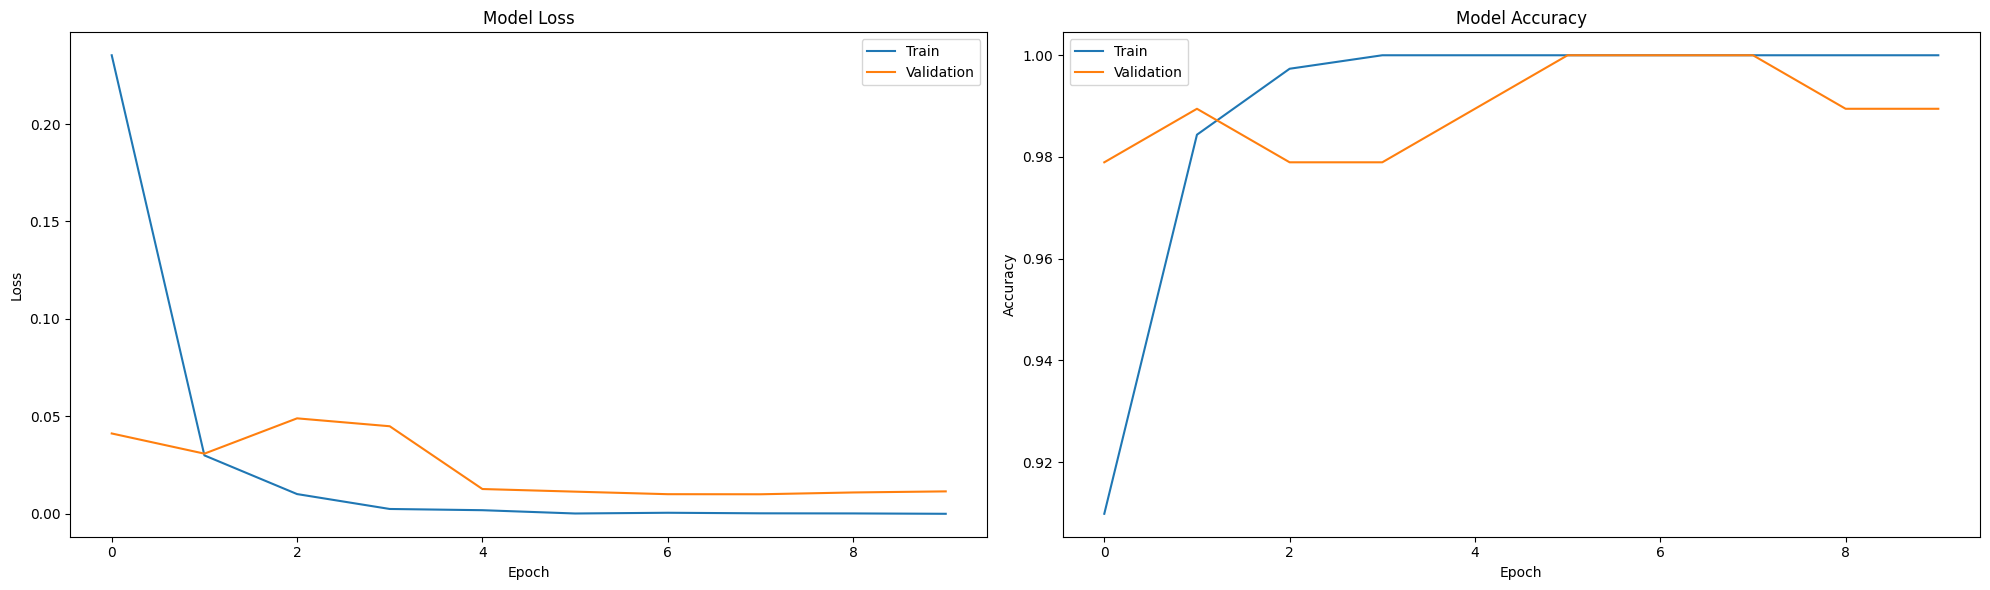

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


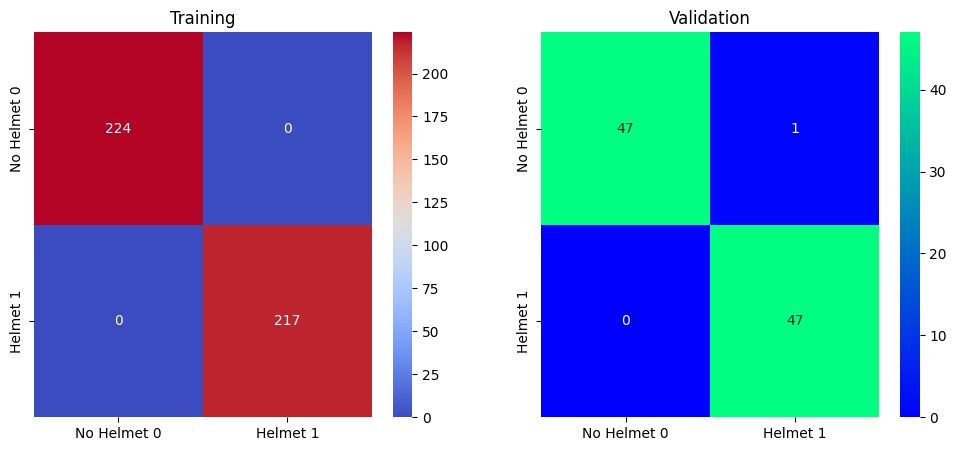

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   
5       VGG_Base: Gray        0.995465             0.989474      0.995465   
6             VGG_FFNN        1.000000             0.989474      1.000000   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   
5           0.989474          0.995505               0.989693  0.995464   
6           0.989474          1.000000               0.989693  1.000000   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943  
5       0.989474  
6       0.989474

In [ ]:
show_performance_metrics(history_vgg16_ffnn, 'VGG_FFNN', model_vgg_ffnn, X_train_normalized, y_train, X_val_normalized, y_val)

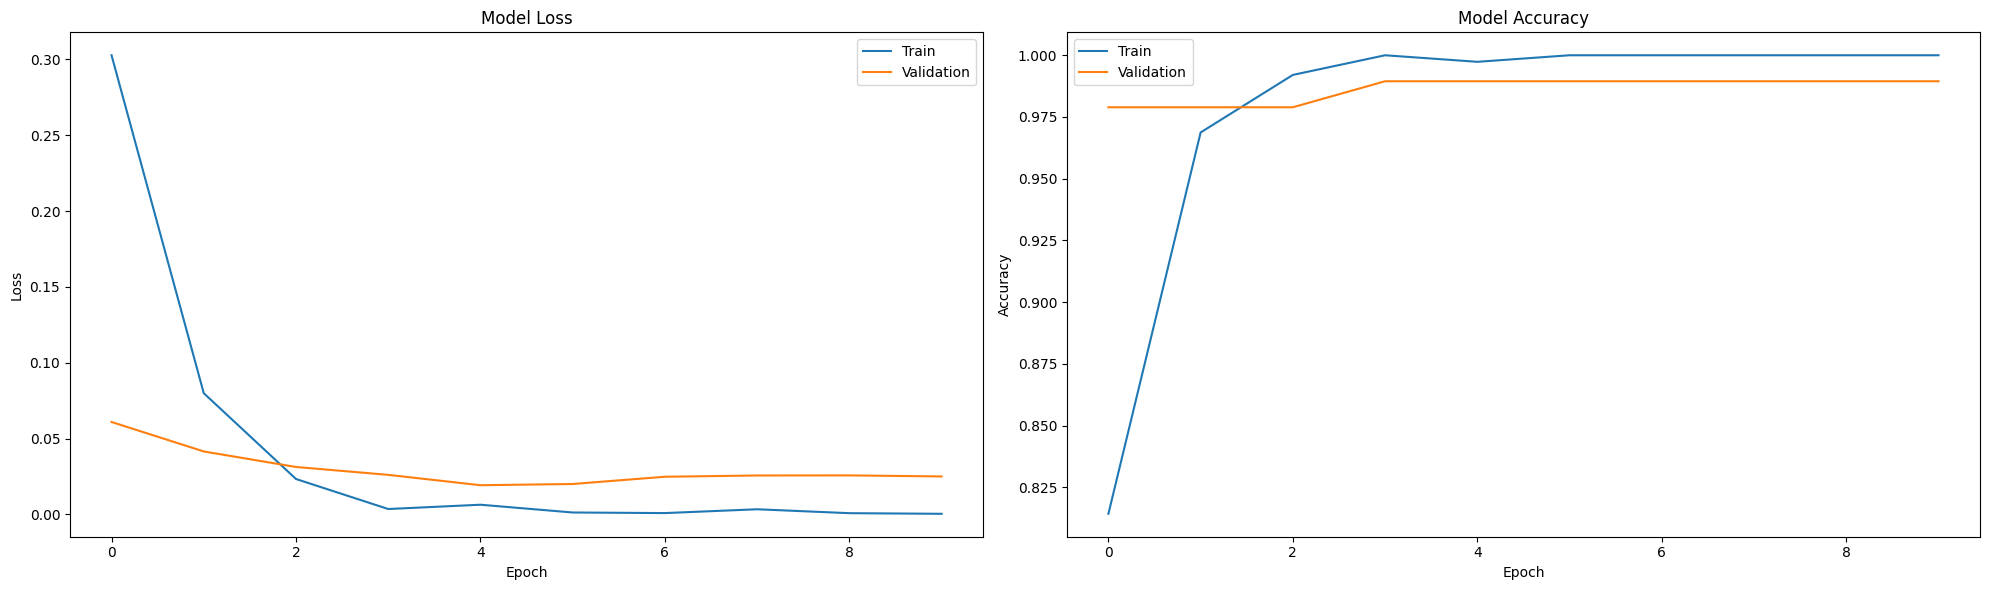

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


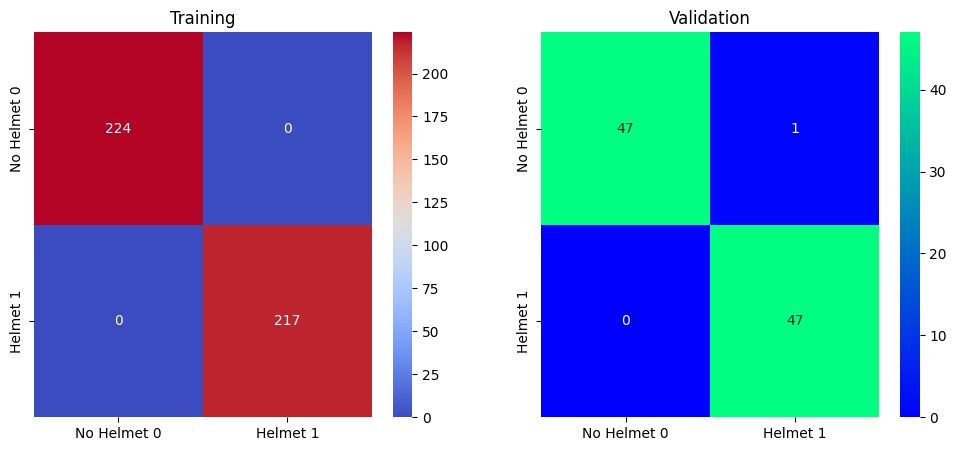

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   
5       VGG_Base: Gray        0.995465             0.989474      0.995465   
6             VGG_FFNN        1.000000             0.989474      1.000000   
7       VGG_FFNN: GRAY        1.000000             0.989474      1.000000   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   
5           0.989474          0.995505               0.989693  0.995464   
6           0.989474          1.000000               0.989693  1.000000   
7           0.989474          1.000000               0.989693  1.000000   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943  
5       0.989474  
6       0.989474  
7       0.989474

In [ ]:
show_performance_metrics(history_vgg16_ffnn_gray, 'VGG_FFNN: GRAY', model_vgg_ffnn_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

#### Visualizing the predictions

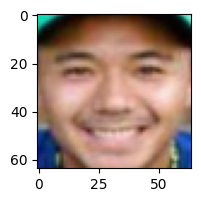

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Probability: 1.7306635413660842e-07, and  Label 0
True Label: 0


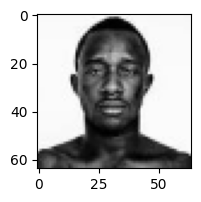

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Probability: 0.5535781383514404, and  Label 1
True Label: 0


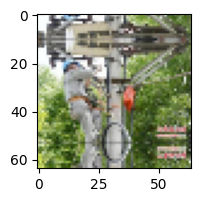

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probability: 0.9999998807907104, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_vgg_ffnn, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

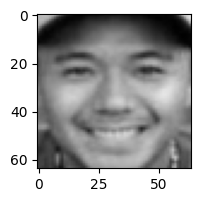

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Probability: 3.8580077671213076e-05, and  Label 0
True Label: 0


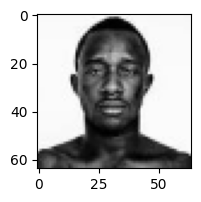

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Probability: 0.8816477656364441, and  Label 1
True Label: 0


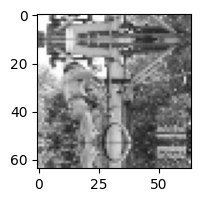

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Probability: 1.0, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_vgg_ffnn_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

### Observation

* We freeze VGG 16 convolution layers , add fully connected neural network with 2 hidden layers and feed it to an output layer.
* FNN uses relu activation function and batch normaliztion (he) and adam optimizer.
* We found that colored model has very good accuracy, recall, precission, f1 against training almost 100% and in validation, almost 99%.
* We found that gray model has very good accuracy, recall, precission, f1 against training almost 100% and in validation, almost 99%.
* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Getting the base vgg 16 model with FFNN
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.3,
                              zoom_range=0.4
                              )

history_vgg16_aug, model_vgg_aug, history_vgg16_aug_gray, model_vgg_aug_gray = get_vgg_model(only_base=False, train_datagen=train_datagen)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6564 - loss: 0.7287 - recall: 0.6327 - val_accuracy: 0.9684 - val_loss: 0.1207 - val_recall: 0.9574
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9844 - loss: 0.1383 - recall: 0.9677 - val_accuracy: 0.9684 - val_loss: 0.0881 - val_recall: 0.9787
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9620 - loss: 0.1024 - recall: 0.9724 - val_accuracy: 0.9789 - val_loss: 0.0504 - val_recall: 0.9787
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0107 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.0491 - val_recall: 0.9787
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9898 - loss: 0.0333 - recall: 0.9876 - val_accuracy: 0.9789 - val_loss: 0.0476 - val_recall: 0.9787
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0360 - recall: 0.9714 - val_accuracy: 0.9789 - val_loss: 0.0458 - val_recall: 0.9787
Epoch 7/10
6/6 ━━━━

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7155 - loss: 0.5536 - recall: 0.6189 - val_accuracy: 0.9789 - val_loss: 0.0704 - val_recall: 1.0000
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0773 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.0588 - val_recall: 1.0000
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9584 - loss: 0.1000 - recall: 0.9726 - val_accuracy: 0.9895 - val_loss: 0.0371 - val_recall: 1.0000
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9825 - loss: 0.0341 - recall: 0.9643 - val_accuracy: 0.9895 - val_loss: 0.0365 - val_recall: 1.0000
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9791 - loss: 0.0768 - recall: 0.9884 - val_accuracy: 0.9895 - val_loss: 0.0378 - val_recall: 1.0000
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9844 - loss: 0.0483 - recall: 1.0000 - val_accuracy: 0.9895 - val_loss: 0.0406 - val_recall: 1.0000
Epoch 7/10
6/6 ━━━━

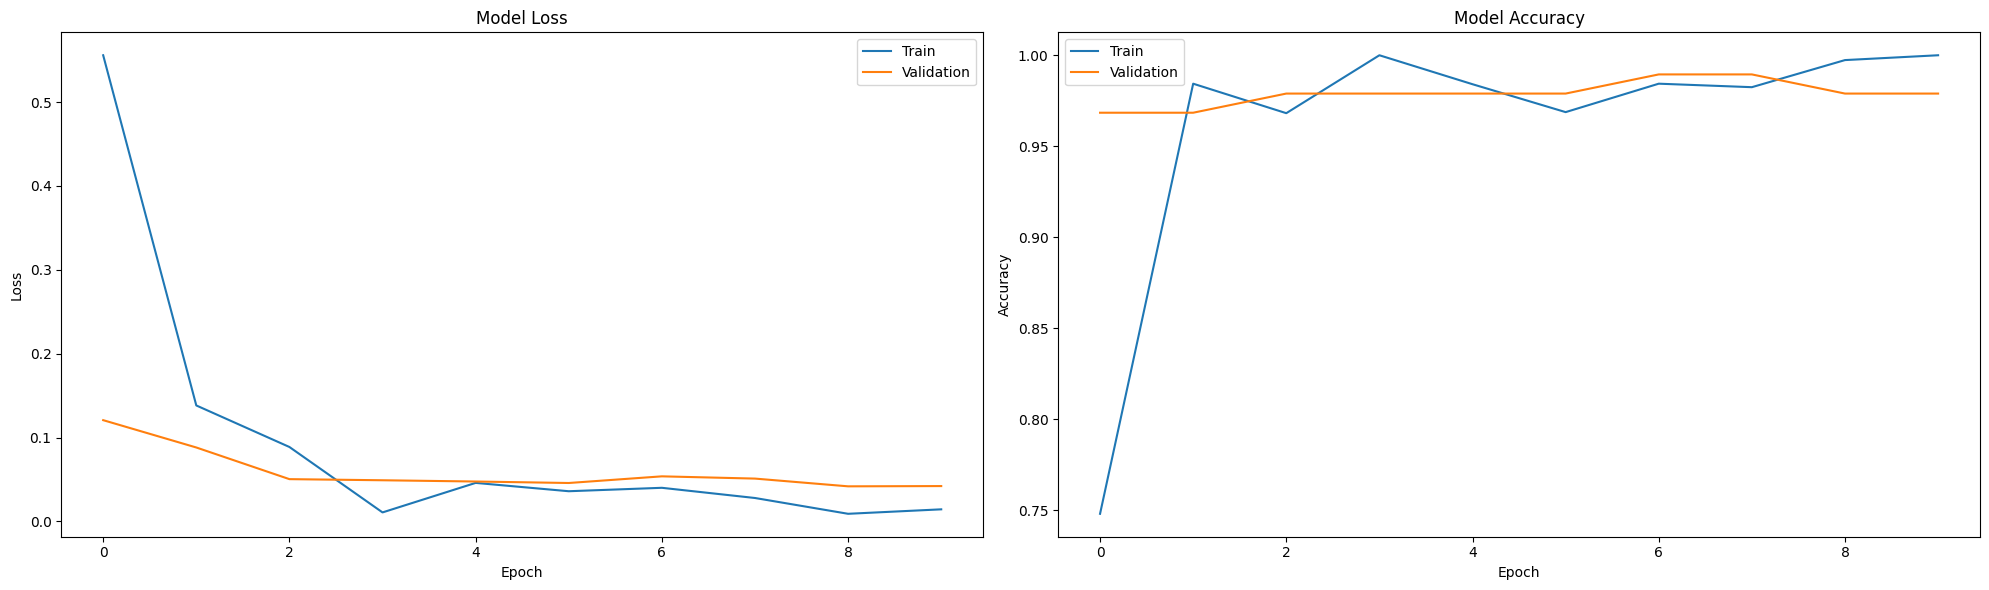

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


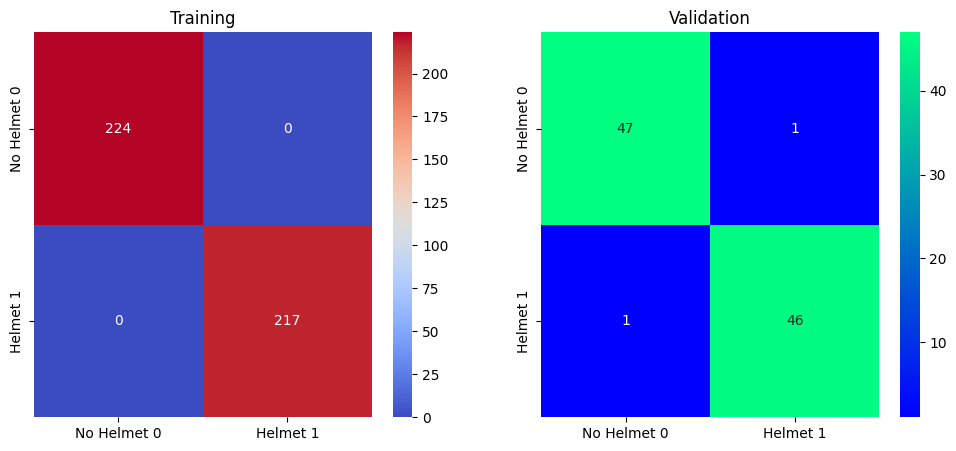

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

 No Helmet 0       0.98      0.98      0.98        48
    Helmet 1       0.98      0.98      0.98        47

    accuracy                           0.98        95
   macro avg       0.98      0.98      0.98        95
weighted avg       0.98      0.98      0.98        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   
5       VGG_Base: Gray        0.995465             0.989474      0.995465   
6             VGG_FFNN        1.000000             0.989474      1.000000   
7       VGG_FFNN: GRAY        1.000000             0.989474      1.000000   
8              VGG_AUG        1.000000             0.978947      1.000000   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   
5           0.989474          0.995505               0.989693  0.995464   
6           0.989474          1.000000               0.989693  1.000000   
7           0.989474          1.000000               0.989693  1.000000   
8           0.978947          1.000000               0.978947  1.000000   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943  
5       0.989474  
6       0.989474  
7       0.989474  
8       0.978947

In [ ]:
show_performance_metrics(history_vgg16_aug, 'VGG_AUG', model_vgg_aug, X_train_normalized, y_train, X_val_normalized, y_val)

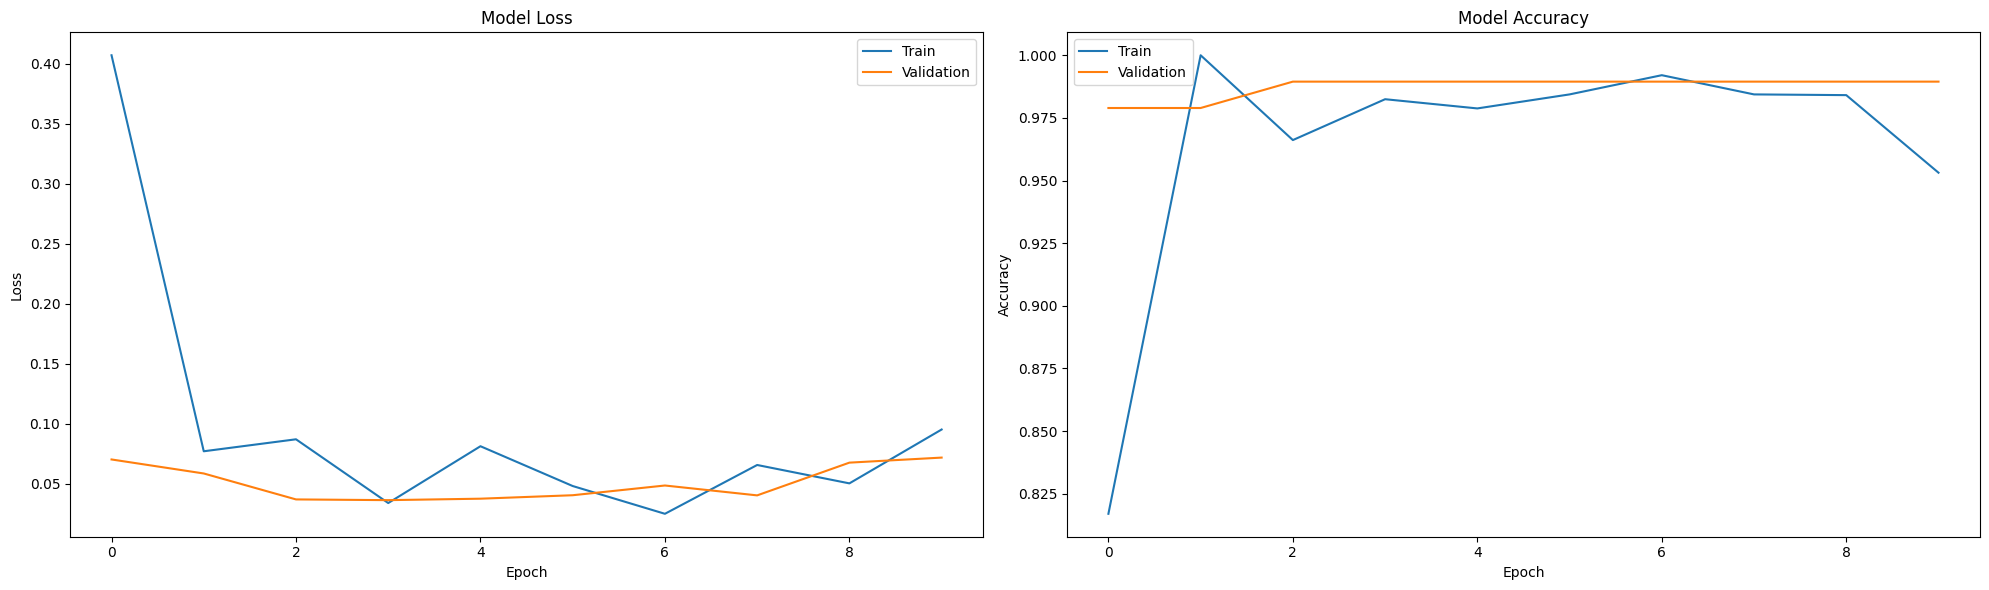

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


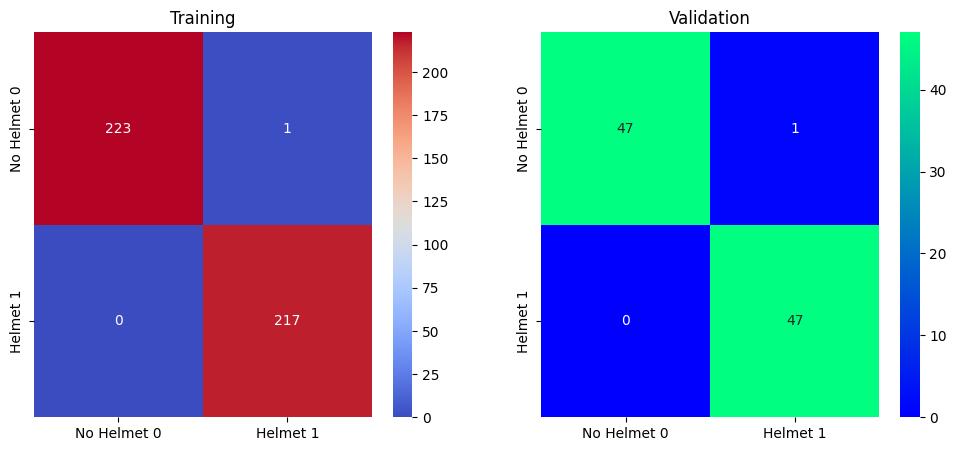

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                  CNN        1.000000             0.978947      1.000000   
1            CNN:Grapy        0.997732             0.989474      0.997732   
2        CNN (Drop=.5)        0.993197             0.978947      0.993197   
3  CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4             VGG_Base        0.995465             0.978947      0.995465   
5       VGG_Base: Gray        0.995465             0.989474      0.995465   
6             VGG_FFNN        1.000000             0.989474      1.000000   
7       VGG_FFNN: GRAY        1.000000             0.989474      1.000000   
8              VGG_AUG        1.000000             0.978947      1.000000   
9        VGG_AUG: GRAY        0.997732             0.989474      0.997732   

   Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0           0.978947          1.000000               0.979807  1.000000   
1           0.989474          0.997743               0.989693  0.997732   
2           0.978947          0.993287               0.978947  0.993196   
3           0.989474          0.979603               0.989693  0.979592   
4           0.978947          0.995506               0.979807  0.995465   
5           0.989474          0.995505               0.989693  0.995464   
6           0.989474          1.000000               0.989693  1.000000   
7           0.989474          1.000000               0.989693  1.000000   
8           0.978947          1.000000               0.978947  1.000000   
9           0.989474          0.997743               0.989693  0.997732   

   Validation_F1  
0       0.978943  
1       0.989474  
2       0.978947  
3       0.989474  
4       0.978943  
5       0.989474  
6       0.989474  
7       0.989474  
8       0.978947  
9       0.989474

In [ ]:
show_performance_metrics(history_vgg16_aug_gray, 'VGG_AUG: GRAY', model_vgg_aug_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

#### Visualizing the predictions

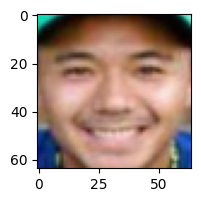

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Probability: 3.548656968632713e-05, and  Label 0
True Label: 0


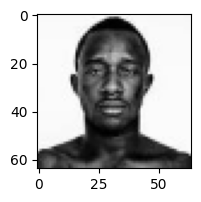

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Probability: 0.9179984331130981, and  Label 1
True Label: 0


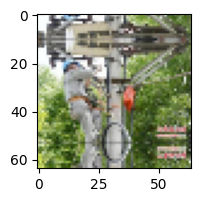

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Probability: 0.9999991655349731, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_vgg_aug, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

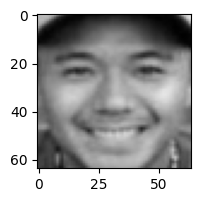

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Probability: 0.00018958865257445723, and  Label 0
True Label: 0


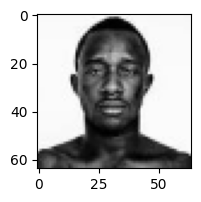

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Probability: 0.9983410835266113, and  Label 1
True Label: 0


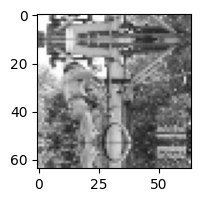

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Probability: 0.9999997615814209, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_vgg_aug_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

### Observation

* We freeze VGG 16 convolution layers , add fully connected neural network with 2 hidden layers and feed it to an output layer.
* FNN uses relu activation function and batch normaliztion (he) and adam optimizer.
* As we have small dataset, So, we augment our training dataset varying rotation, using horizontal, and vertical flipping, zooming, etc. The objective is to increase the training datasets with all varieties to avoid overfitting.
* We found that colored image model has very good accuracy, recall, precission, f1 against training almost 100% and in validation, almost 98%.
* We found that gray image model has very good accuracy, recall, precission, f1 against training almost 99.7% and in validation, almost 99%.
* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

## Model 5: (VGG-16 (Base + FFNN + Data Augmentation + Dropout)

In [ ]:
history_vgg16_aug_drop, model_vgg_aug_drop, history_vgg16_aug_drop_gray, model_vgg_aug_drop_gray = get_vgg_model(only_base=False, train_datagen=train_datagen, drop_out_rate=dropout_rate)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5716 - loss: 0.8034 - recall: 0.5392 - val_accuracy: 0.9263 - val_loss: 0.2013 - val_recall: 0.8511
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - loss: 0.3837 - recall: 0.6970 - val_accuracy: 0.9263 - val_loss: 0.1905 - val_recall: 0.8511
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8900 - loss: 0.2640 - recall: 0.8513 - val_accuracy: 0.9789 - val_loss: 0.0569 - val_recall: 1.0000
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9062 - loss: 0.2010 - recall: 0.9706 - val_accuracy: 0.9789 - val_loss: 0.0536 - val_recall: 1.0000
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9434 - loss: 0.1342 - recall: 0.9576 - val_accuracy: 0.9789 - val_loss: 0.0475 - val_recall: 0.9574
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9844 - loss: 0.0662 - recall: 1.0000 - val_accuracy: 0.9789 - val_loss: 0.0491 - val_recall: 0.9574
Epoch 7/10
6/6 ━━━━

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,257 (58.26 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6258 - loss: 0.7246 - recall: 0.5161 - val_accuracy: 0.9684 - val_loss: 0.1155 - val_recall: 0.9787
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8281 - loss: 0.3493 - recall: 0.7419 - val_accuracy: 0.9684 - val_loss: 0.0946 - val_recall: 0.9787
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8802 - loss: 0.2530 - recall: 0.8991 - val_accuracy: 0.9789 - val_loss: 0.0519 - val_recall: 0.9787
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9219 - loss: 0.2192 - recall: 0.8824 - val_accuracy: 0.9789 - val_loss: 0.0494 - val_recall: 0.9787
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9596 - loss: 0.1207 - recall: 0.9836 - val_accuracy: 0.9895 - val_loss: 0.0449 - val_recall: 1.0000
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9688 - loss: 0.0672 - recall: 0.9667 - val_accuracy: 0.9895 - val_loss: 0.0451 - val_recall: 1.0000
Epoch 7/10
6/6 ━━━━

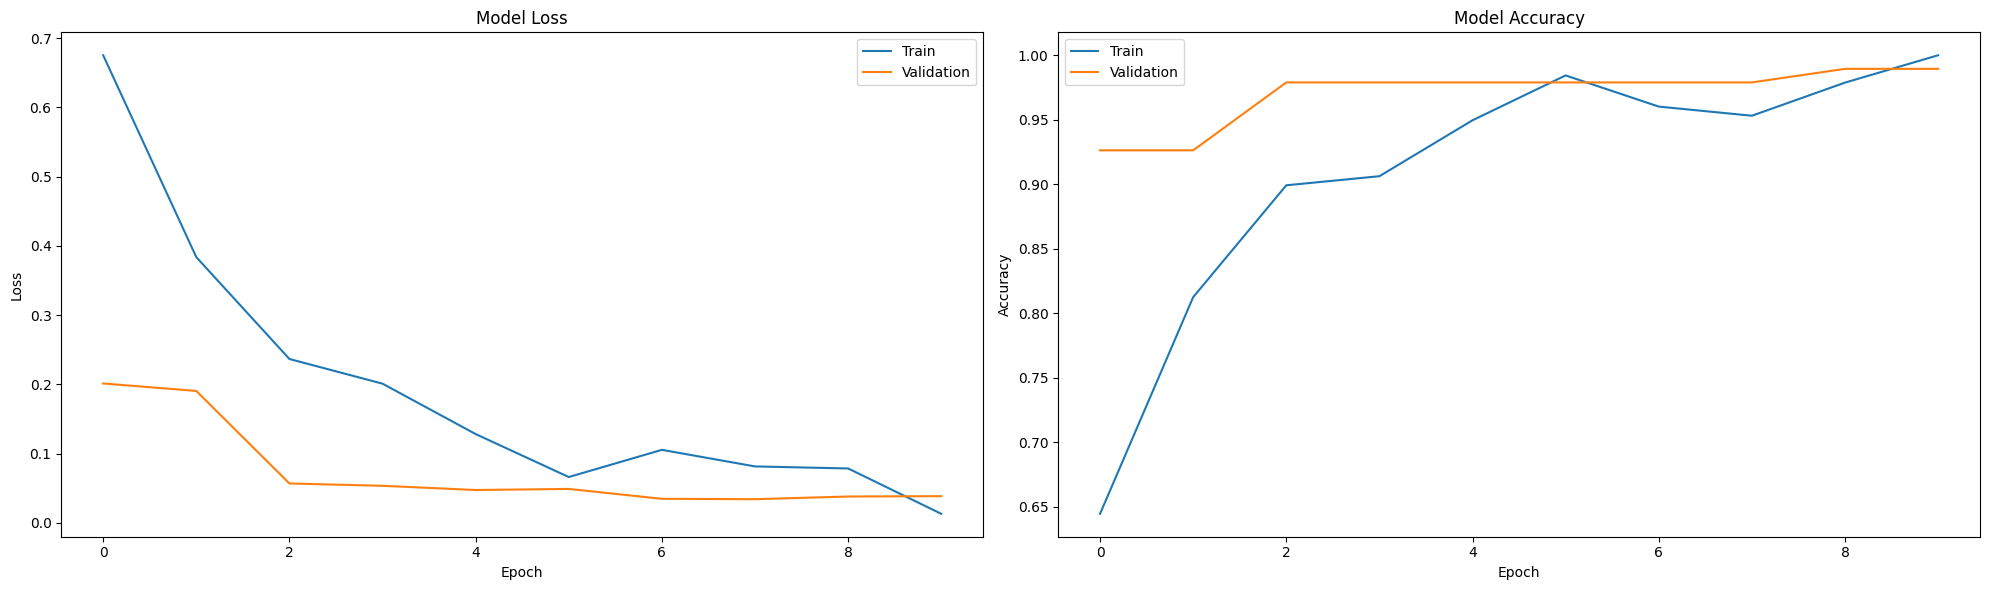

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


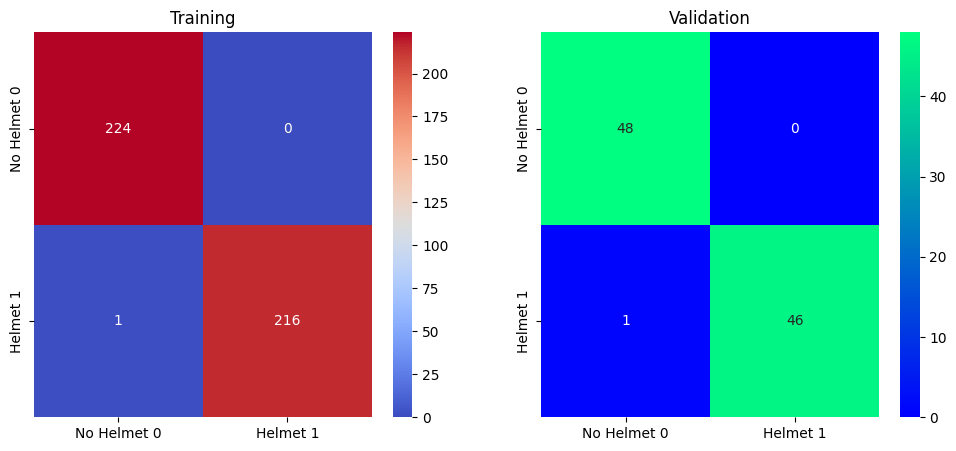

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

 No Helmet 0       0.98      1.00      0.99        48
    Helmet 1       1.00      0.98      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  Train_Recall  \
0                   CNN        1.000000             0.978947      1.000000   
1             CNN:Grapy        0.997732             0.989474      0.997732   
2         CNN (Drop=.5)        0.993197             0.978947      0.993197   
3   CNN (Drop=.5): Gray        0.979592             0.989474      0.979592   
4              VGG_Base        0.995465             0.978947      0.995465   
5        VGG_Base: Gray        0.995465             0.989474      0.995465   
6              VGG_FFNN        1.000000             0.989474      1.000000   
7        VGG_FFNN: GRAY        1.000000             0.989474      1.000000   
8               VGG_AUG        1.000000             0.978947      1.000000   
9         VGG_AUG: GRAY        0.997732             0.989474      0.997732   
10  VGG16_AUG (Drop=.5)        0.997732             0.989474      0.997732   

    Validation_Recall  Train_Precission  Validation_Precission  Train_F1  \
0            0.978947          1.000000               0.979807  1.000000   
1            0.989474          0.997743               0.989693  0.997732   
2            0.978947          0.993287               0.978947  0.993196   
3            0.989474          0.979603               0.989693  0.979592   
4            0.978947          0.995506               0.979807  0.995465   
5            0.989474          0.995505               0.989693  0.995464   
6            0.989474          1.000000               0.989693  1.000000   
7            0.989474          1.000000               0.989693  1.000000   
8            0.978947          1.000000               0.978947  1.000000   
9            0.989474          0.997743               0.989693  0.997732   
10           0.989474          0.997743               0.989689  0.997732   

    Validation_F1  
0        0.978943  
1        0.989474  
2        0.978947  
3        0.989474  
4        0.978943  
5        0.989474  
6        0.989474  
7        0.989474  
8        0.978947  
9        0.989474  
10       0.989471

In [ ]:
show_performance_metrics(history_vgg16_aug_drop, 'VGG16_AUG (Drop=.5)', model_vgg_aug_drop, X_train_normalized, y_train, X_val_normalized, y_val)

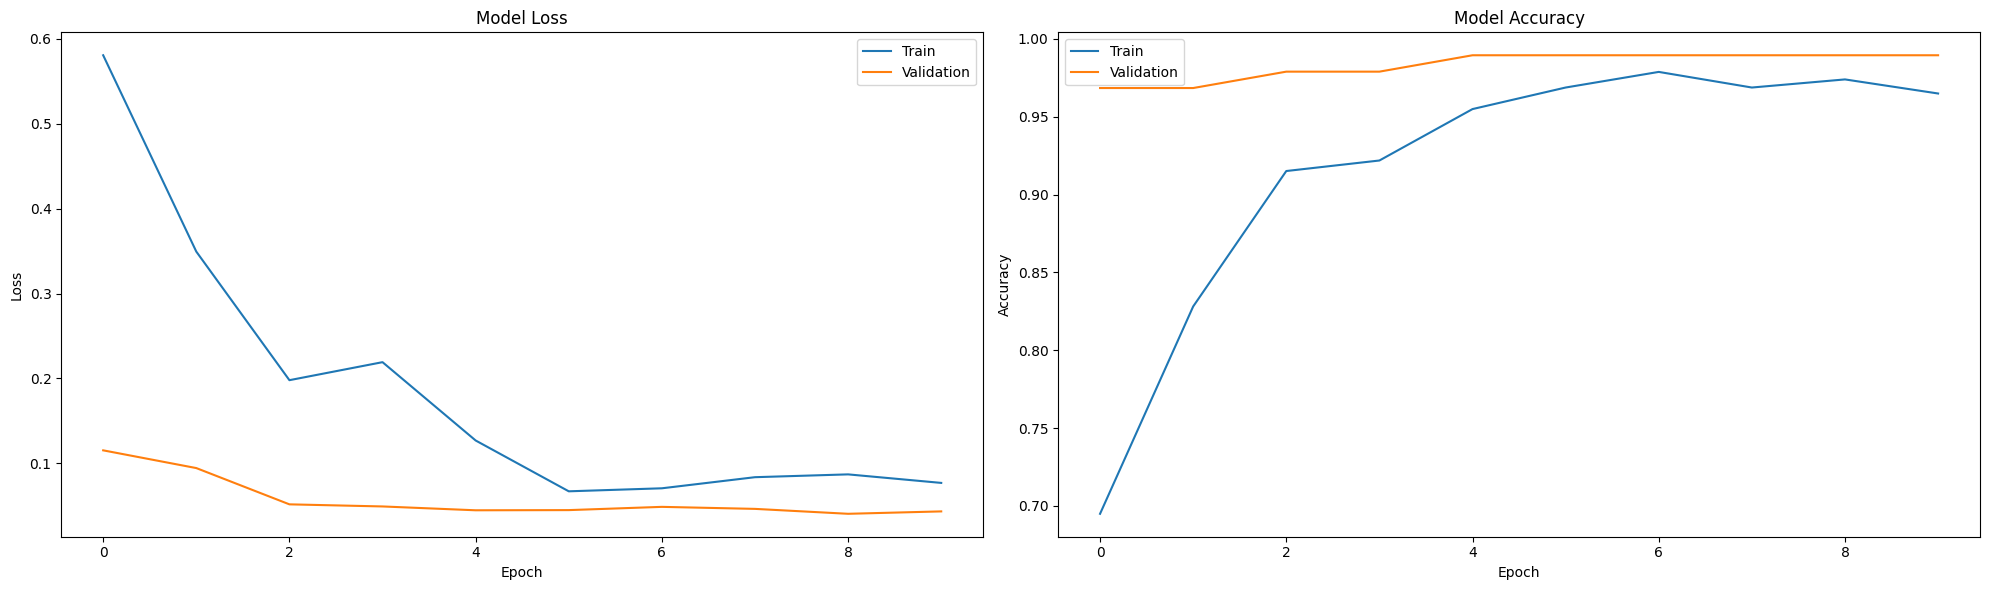

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


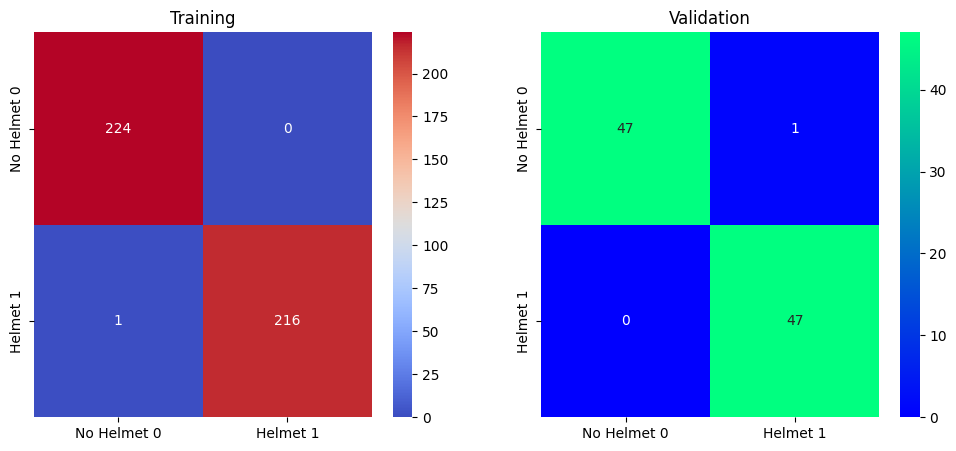

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      0.98      0.99        48
    Helmet 1       0.98      1.00      0.99        47

    accuracy                           0.99        95
   macro avg       0.99      0.99      0.99        95
weighted avg       0.99      0.99      0.99        95



model  Train_Accuracy  Validation_Accuracy  \
0                         CNN        1.000000             0.978947   
1                   CNN:Grapy        0.997732             0.989474   
2               CNN (Drop=.5)        0.993197             0.978947   
3         CNN (Drop=.5): Gray        0.979592             0.989474   
4                    VGG_Base        0.995465             0.978947   
5              VGG_Base: Gray        0.995465             0.989474   
6                    VGG_FFNN        1.000000             0.989474   
7              VGG_FFNN: GRAY        1.000000             0.989474   
8                     VGG_AUG        1.000000             0.978947   
9               VGG_AUG: GRAY        0.997732             0.989474   
10        VGG16_AUG (Drop=.5)        0.997732             0.989474   
11  VGG16_AUG (Drop=.5): GRAY        0.997732             0.989474   

    Train_Recall  Validation_Recall  Train_Precission  Validation_Precission  \
0       1.000000           0.978947          1.000000               0.979807   
1       0.997732           0.989474          0.997743               0.989693   
2       0.993197           0.978947          0.993287               0.978947   
3       0.979592           0.989474          0.979603               0.989693   
4       0.995465           0.978947          0.995506               0.979807   
5       0.995465           0.989474          0.995505               0.989693   
6       1.000000           0.989474          1.000000               0.989693   
7       1.000000           0.989474          1.000000               0.989693   
8       1.000000           0.978947          1.000000               0.978947   
9       0.997732           0.989474          0.997743               0.989693   
10      0.997732           0.989474          0.997743               0.989689   
11      0.997732           0.989474          0.997743               0.989693   

    Train_F1  Validation_F1  
0   1.000000       0.978943  
1   0.997732       0.989474  
2   0.993196       0.978947  
3   0.979592       0.989474  
4   0.995465       0.978943  
5   0.995464       0.989474  
6   1.000000       0.989474  
7   1.000000       0.989474  
8   1.000000       0.978947  
9   0.997732       0.989474  
10  0.997732       0.989471  
11  0.997732       0.989474

In [ ]:
show_performance_metrics(history_vgg16_aug_drop_gray, 'VGG16_AUG (Drop=.5): GRAY', model_vgg_aug_drop_gray, X_train_normalized_gray, y_train_gray, X_val_normalized_gray, y_val_gray)

#### Visualizing the predictions

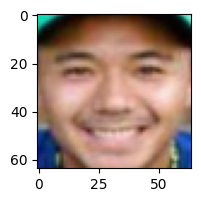

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Probability: 0.00039803964318707585, and  Label 0
True Label: 0


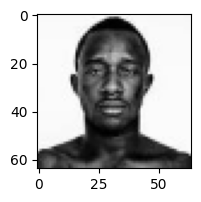

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Probability: 0.47181960940361023, and  Label 0
True Label: 0


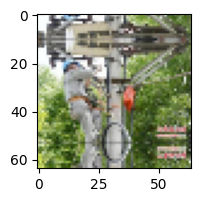

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Probability: 0.9999116659164429, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val, X_val_normalized, y_val, model_vgg_aug_drop, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

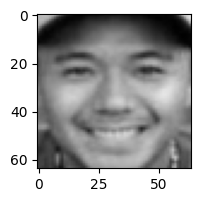

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Probability: 0.0005008371663279831, and  Label 0
True Label: 0


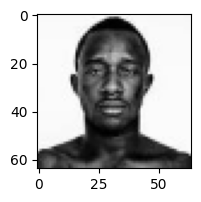

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Probability: 0.9678416848182678, and  Label 1
True Label: 0


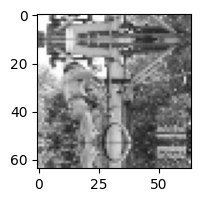

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Probability: 0.9999979734420776, and  Label 1
True Label: 1


In [ ]:
show_visulization(X_val_gray, X_val_normalized_gray, y_val_gray, model_vgg_aug_drop_gray, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL, index=[2, 10, 23])

* We freeze VGG 16 convolution layers , add fully connected neural network with 2 hidden layers and feed it to an output layer.
* FNN uses relu activation function and batch normaliztion (he) and adam optimizer.
* As we have small dataset, So, we augment our training dataset varying rotation, using horizontal, and vertical flipping, zooming, etc. The objective is to increase the training datasets with all varieties to avoid overfitting.
* We used 50% drop out to avoid overfitting
* We found that both color and gray imge models have very good accuracy, recall, precission, and f1 against training, is almost 99.7% and validation, almost 99%.
* We visualized some images (index 2, 10, 23 randomly) and predicted them. The model correctly predicted them.

# **Model Performance Comparison and Final Model Selection**

In [ ]:
results_eval

model  Train_Accuracy  Validation_Accuracy  \
0                         CNN        1.000000             0.978947   
1                   CNN:Grapy        0.997732             0.989474   
2               CNN (Drop=.5)        0.993197             0.978947   
3         CNN (Drop=.5): Gray        0.979592             0.989474   
4                    VGG_Base        0.995465             0.978947   
5              VGG_Base: Gray        0.995465             0.989474   
6                    VGG_FFNN        1.000000             0.989474   
7              VGG_FFNN: GRAY        1.000000             0.989474   
8                     VGG_AUG        1.000000             0.978947   
9               VGG_AUG: GRAY        0.997732             0.989474   
10        VGG16_AUG (Drop=.5)        0.997732             0.989474   
11  VGG16_AUG (Drop=.5): GRAY        0.997732             0.989474   

    Train_Recall  Validation_Recall  Train_Precission  Validation_Precission  \
0       1.000000           0.978947          1.000000               0.979807   
1       0.997732           0.989474          0.997743               0.989693   
2       0.993197           0.978947          0.993287               0.978947   
3       0.979592           0.989474          0.979603               0.989693   
4       0.995465           0.978947          0.995506               0.979807   
5       0.995465           0.989474          0.995505               0.989693   
6       1.000000           0.989474          1.000000               0.989693   
7       1.000000           0.989474          1.000000               0.989693   
8       1.000000           0.978947          1.000000               0.978947   
9       0.997732           0.989474          0.997743               0.989693   
10      0.997732           0.989474          0.997743               0.989689   
11      0.997732           0.989474          0.997743               0.989693   

    Train_F1  Validation_F1  
0   1.000000       0.978943  
1   0.997732       0.989474  
2   0.993196       0.978947  
3   0.979592       0.989474  
4   0.995465       0.978943  
5   0.995464       0.989474  
6   1.000000       0.989474  
7   1.000000       0.989474  
8   1.000000       0.978947  
9   0.997732       0.989474  
10  0.997732       0.989471  
11  0.997732       0.989474

### Observation
* All the models have almost 97-100% accuracy, recall, precission and F1 score both in training and testing.
* This is because of size of dataset and I believe, dataset is very clean and proccessed.
* Upon all of the above, I will choose VGG16 with augmentation and drop out of 50% as it will give stable or resilient prediction performance (theoretically) in unseen environment with realtime work monitoring. It's recall and f1 score in training is almost 99.5% but in testing 98% (very close and not 100%).
Moreover, Model built with augmented training data learns varities of images with different positioning, and dropping out in hidden layer with help to overcome overfitting.
* Although VGG-16 augmentation with 50% drop out models for both color and gray images have the same result, we will pick the color image model as it trains will all color channels and can predict color images without converting to gray scale.

## Test Performance

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


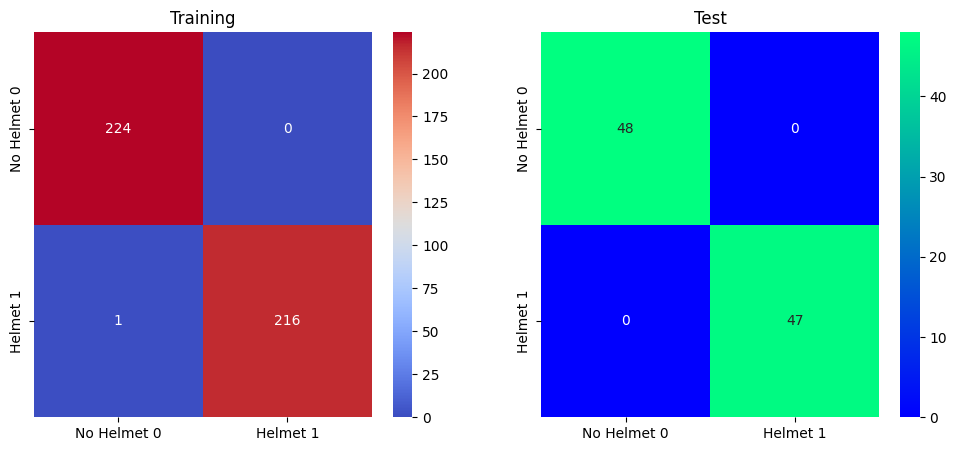

Classification Report
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

 No Helmet 0       1.00      1.00      1.00        48
    Helmet 1       1.00      1.00      1.00        47

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



model  Train_Accuracy  Testing_Accuracy  Train_Recall  \
0  VGG16_AUG (Drop=.5)        0.997732               1.0      0.997732   

   Testing_Recall  Train_Precission  Testing_Precission  Train_F1  Testing_F1  
0             1.0          0.997743                 1.0  0.997732         1.0

In [ ]:
columns_eval_metric = ["model", "Train_Accuracy","Testing_Accuracy", "Train_Recall", "Testing_Recall", "Train_Precission", "Testing_Precission", "Train_F1","Testing_F1"]

results_eval = pd.DataFrame(columns=columns_eval_metric)
show_performance_metrics(history_vgg16_aug_drop, 'VGG16_AUG (Drop=.5)', model_vgg_aug_drop, X_train_normalized, y_train, X_test_normalized, y_test, is_testing = True)

### Observation
* VGG augmented color image model with drop out of 50% has also good testing evaluation metrics of 100%

# **Actionable Insights & Recommendations**

### Actionable Insight

* We build models using colored and gray scaled images. Hence, we have 12 models.
* We classified images of human with safe helmet in their working place. We were given a dataset of 631 images and 320 of them are without helmet and 311 are with helmet.

* The dataset is very small and uniformly distributed. Therefore, we have amost 97-100% accuracy by all models (colored and gray scaled) of training, validation, and testing performance and have overfitting.

* We observe that, basic CNN/CNN with drop out (50%) has 97% validation recall where as all VGG-16 models (basic, FFNN, AUG, and AUG with drop out of 50%) have almost 99% validation records. This proofs that VGG-16 pre-trained features were beneficial, further refining them with an additional neural network tailored to different dataset enhanced the results.

* However, all the VGG-16-based models are experiencing overfitting. To address this, data augmentation techniques and drop out of 50% can be applied as a form of regularization with the additional varieties for datasets in different work places.

* We choose VGG augmented colored image model with drop out of 50% as to overcome overfitting. It has also good testing evaluation metrics of 100%

### Recommendation
* Business can integrate this model into their real-time workplace safety monitoring system, and incrementally improve model by feeding more data.

* These models can be further improved by training with different filter sizes and different number of filters.

* These models can also be trained on the original image_size i.e 200 x 200 rather than being reduced to 64.

* Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.

* Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

-
-

<font size=5 color='blue'>Power Ahead!</font>
___